# Time series analysis project
### Applying time series concepts on Airline passengers dataset and why some algorithms failed and why some algorithms succeeded

# Project team members
1) Ahmed hany youssef mohammed    ahmedhanya1000@gmail.com

2) Kerolos yacoub sabri zaki              kerolos20140659@yahoo.com

3) Khaled Adel Thabet Mostafa                khaledadelali1998@gmail.com

4) Mustafa Mohamed Mahmoud Abdelrahim              mustafamahamed12@gmail.com

5) Omar Mohamed Anwar Esmail               Omar_Mohamed_Anwer@hotmail.com

6) Salma Amgad Hassan ElBaik               salmaelbaik@gmail.com

In [138]:
import numpy as np
import pandas as pd

#Visualizing the data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_style("dark")

# for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

#Evaluation Metric
from sklearn.metrics import mean_squared_error

#Spiltting the data
from sklearn.model_selection import TimeSeriesSplit

#Models
from statsmodels.tsa.arima.model import ARIMA


from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

from pylab import rcParams


In [ ]:
def plots(actual,preds,model_name):
  # plot something in the top subplot
  plt.plot(df.Month.iloc[:120], actual[:120])
  plt.plot(df.Month.iloc[120:], actual[120:])
  plt.plot(df.Month, preds)
  plt.xlabel('Date')
  plt.ylabel('Passengers')
  plt.title(f'{model_name}') 
  plt.legend(["actual - train","actual - test", "preds"], loc ="lower right")
  plt.show()

We chose RMSE because it represents the unit of the problem so we can know exactly how many passengers are error calculated.

# Setting the evaluators

#evaluate using **FIXED PARTITIONING**

In [ ]:
def Fixed_forecast(data,train_size,model):
  train_df = data.iloc[:train_size]
  actuals = data.iloc[train_size:]
  preds = model(train_df).predict(start=train_df.shape[0], end=(train_df.shape[0]+actuals.shape[0])-1)

  return actuals,preds

#evaluate using **MULTIPLE SPLITS**

In [ ]:
# tss forcasting golbal functions "don't touch :)"

def tss_forecast(data,n_splits,model):
  tscv = TimeSeriesSplit(n_splits=n_splits)

  actuals = np.array([])
  preds = np.array([])
  
  for train_index, test_index in tscv.split(data):
    train_data = data[train_index]
    test_data = data[test_index]
    y_pred = model(train_data).forecast(steps=len(test_data))
    
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)
  
  return actuals,preds


#evaluate using **ROLL FORWARD**

This method gets the best RMSE in all models except the machine learning ones since they work better on Fixed Splitting

In [ ]:
# rolling forcasting golbal functions "don't touch :)"

def rolling_forecast_generator(data,window_size):
  for i in range(len(data)-window_size):
    yield data[:i+window_size]

def rolling_forecast(data,window_size,model):
  actuals = data[window_size:]
  preds = np.array([model(train_data).forecast(steps=1) for train_data in rolling_forecast_generator(data,window_size)]).reshape(-1)
  return actuals,preds


#Loading the data

In [164]:
df = pd.read_csv("/content/airline-passengers.csv")

df2 = pd.read_csv('/content/airline-passengers.csv', index_col='Month', parse_dates=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [151]:
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.sample(5)

,Month,Passengers
141,1960-10-01,461
14,1950-03-01,141
88,1956-05-01,318
27,1951-04-01,163
71,1954-12-01,229


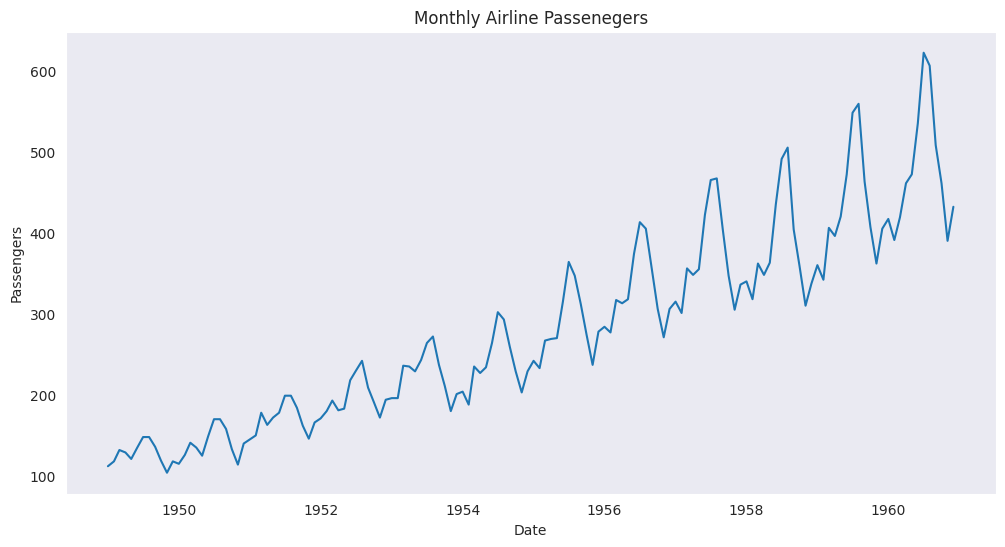

In [ ]:
plt.figure(figsize=(12,6));
plt.plot(df.Month, df.Passengers);
plt.xlabel('Date');
plt.ylabel('Passengers');
plt.title('Monthly Airline Passenegers');

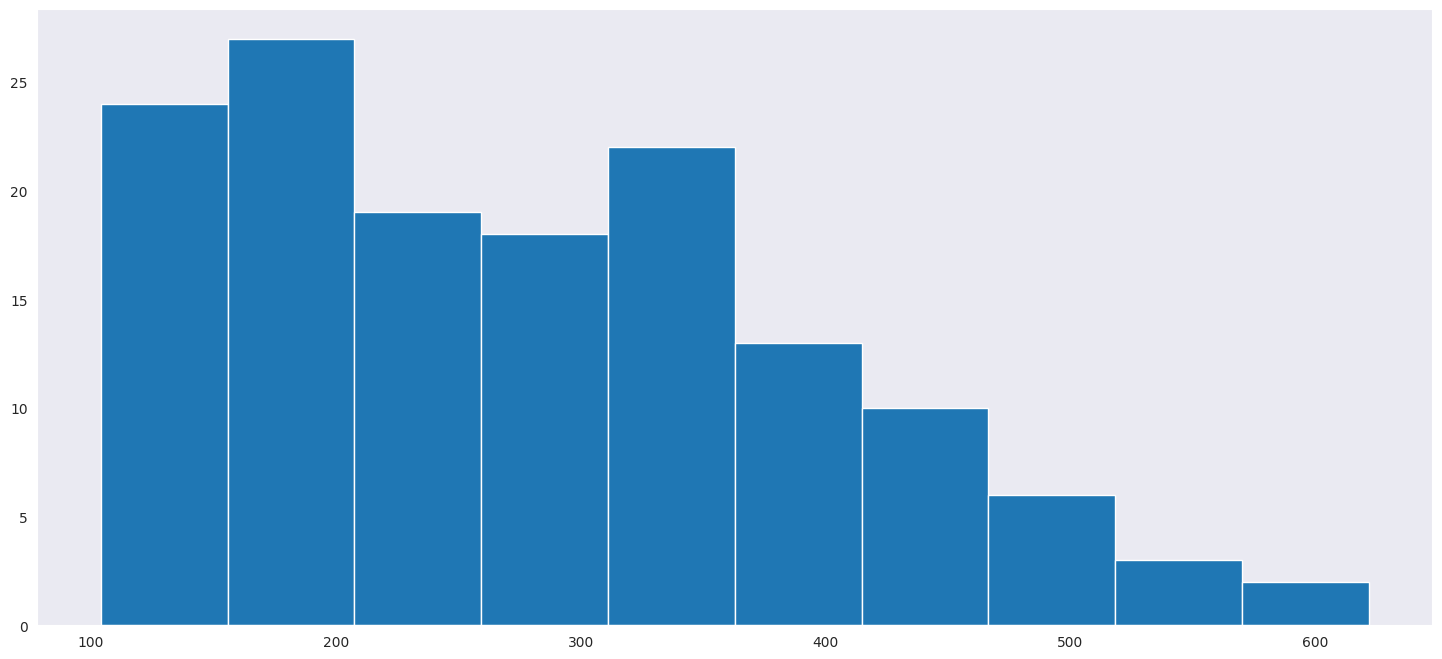

In [170]:
# Plotting histogram to see distribution of data.
plt.hist(df.Passengers)
plt.show()

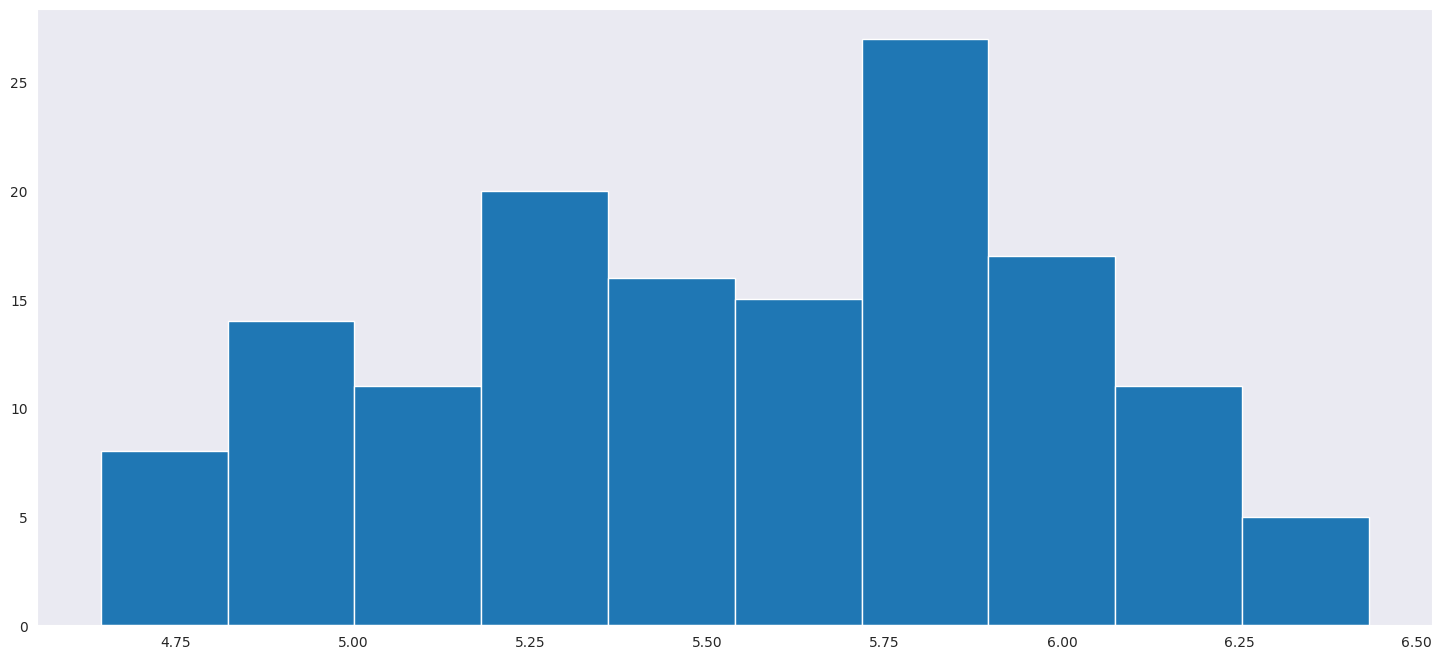

In [169]:
# Using log to fix skewness of data.
plt.hist(np.log(df.Passengers))
plt.show()

# Models

# 1. Simple Average

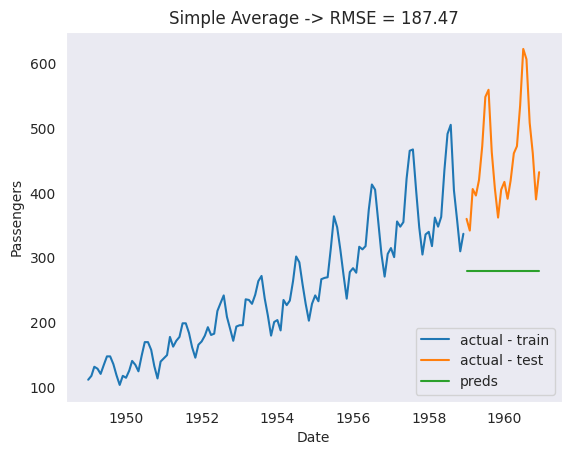

In [ ]:
time_period = len(df['Passengers'])
train_size = 120
pred = df.rolling(window=time_period).mean()
preds = [pred["Passengers"].iloc[-1]]*len(df['Passengers'])
rmse = mean_squared_error(df['Passengers'][train_size:], preds[train_size:], squared=False)
preds[:train_size] = [np.nan] * train_size
plots(df['Passengers'],preds,f"Simple Average -> RMSE = {round(rmse,2)}")

# 2. Moving Average

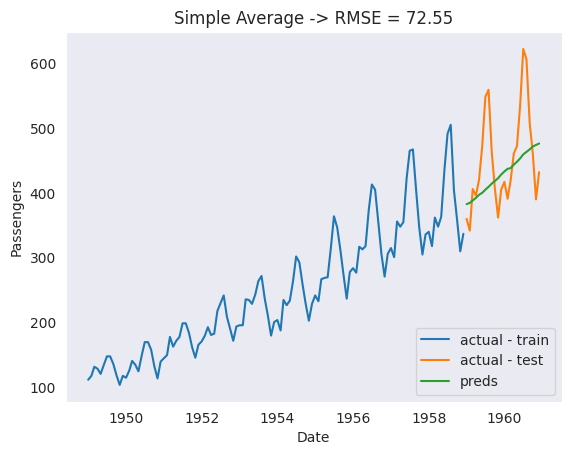

In [ ]:
time_period = 12
train_size = 120
preds = df.rolling(window=time_period).mean()
rmse = mean_squared_error(df['Passengers'][train_size+time_period-1:], preds[train_size+time_period-1:], squared=False)
preds[:train_size] = np.nan
plots(df['Passengers'],preds,f"Moving Average -> RMSE = {round(rmse,2)}")

In [136]:
# multiple train test splits
tscv = TimeSeriesSplit(n_splits=5)
actuals = np.array([])
preds = np.array([])
window_size=12

for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]

    rolling_mean = train_data.rolling(window=window_size).mean()
    y_pred = pd.Series(rolling_mean.iloc[-1], index=test_data.index)

    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)

rmse = mean_squared_error(actuals, preds, squared=False)
print('multiple splits forecast RMSE:', rmse)

multiple splits forecast RMSE: 74.66372762072774


In [137]:
window_size = 12

# rolling forward evaluation with moving average
tscv = TimeSeriesSplit(test_size=1, n_splits=20, max_train_size=120)
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]
    y_pred = pd.Series(train_data.rolling(window=window_size).mean().iloc[-1], index=test_data.index)
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)
rmse = mean_squared_error(actuals, preds, squared=False)
print('rolling forward RMSE with moving average:', rmse)

rolling forward RMSE with moving average: 80.59523783146936


# 2. Naive Forecasting

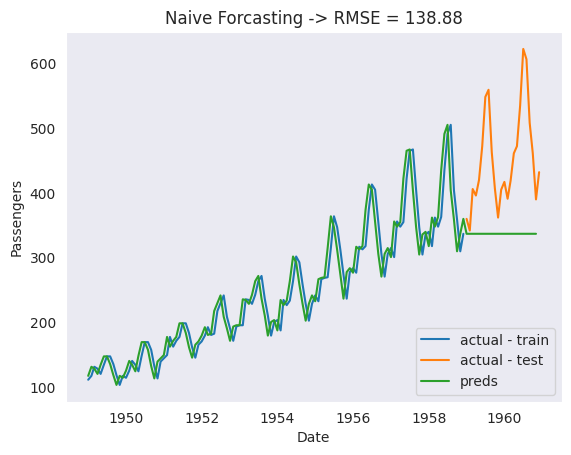

In [ ]:
preds = df['Passengers'].shift(-1)
# train test split with respect to order
train_size = 120
df_train, df_test = df['Passengers'].iloc[:train_size], df['Passengers'].iloc[train_size:-1]
preds[train_size:-1] = [df_train.iloc[-1]] * len(preds[train_size:-1])
rmse = mean_squared_error(df_test, preds[train_size:-1], squared=False)
plots(df['Passengers'],preds,f"Naive Forcasting -> RMSE = {round(rmse,2)}")

In [ ]:
# multiple train test splits
tscv = TimeSeriesSplit(n_splits=5)
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]
    y_pred = pd.Series(train_data.iloc[-1], index=test_data.index)
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)
rmse = mean_squared_error(actuals, preds, squared=False)
print('multiple splits forecast RMSE:', rmse)

multiple splits forecast RMSE: 89.7359552613481


In [ ]:
# rolling forward evaluation
tscv = TimeSeriesSplit(test_size = 1,n_splits = 20,max_train_size = 120)
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]
    y_pred = pd.Series(train_data.iloc[-1], index=test_data.index)
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)
rmse = mean_squared_error(actuals, preds, squared=False)
print('rolling forward RMSE:', rmse)

rolling forward RMSE: 54.45365001540301


# 3. Weighted Moving Average

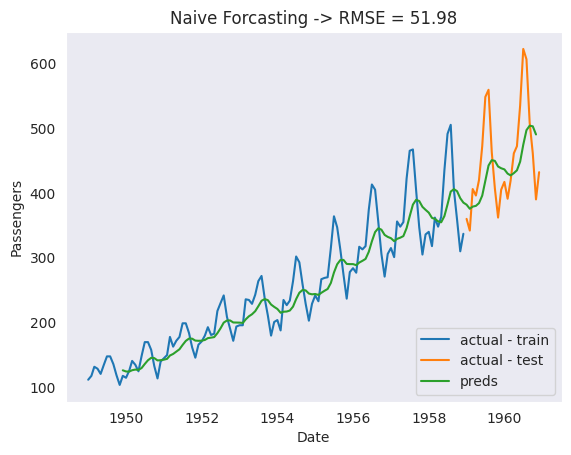

In [135]:
window_size=12
weights = 0.1 * np.array(range(1,window_size +1))
weights = weights/weights.sum()
def weighted_average(weights):
    def func(x):
        return (weights * x).sum()
    return func

# Calculate the weighted moving average
weighted_average_func = weighted_average(weights)
wma = df["Passengers"].rolling(window_size).apply(weighted_average_func)

# Calculate the RMSE
actuals = df["Passengers"][window_size:]
preds = [np.nan] * len(df['Passengers'])
preds[window_size-1:-1] = wma[window_size-1:-1]
rmse = mean_squared_error(actuals, preds[window_size-1:-1], squared=False)

plots(df['Passengers'],preds,f"Weighted Moving Average -> RMSE = {round(rmse,2)}")


In [171]:
# multiple train test splits

# perform time series split
tscv = TimeSeriesSplit(n_splits=5)
actuals = np.array([])
preds = np.array([])

for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]

    # calculate weighted moving average on training data
    weighted_average_func = weighted_average(weights)
    wma_train = train_data.rolling(window_size).apply(weighted_average_func)

    # forecast using the last value of training data
    y_pred = pd.Series(wma_train.iloc[-1], index=test_data.index)

    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)

# calculate RMSE
rmse = mean_squared_error(actuals, preds, squared=False)
print('multiple splits forecast RMSE:', rmse)

multiple splits forecast RMSE: 71.99471750838684


In [180]:
#the rolling forward evaluation
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(df['Passengers']):
    train_data = df['Passengers'][train_index]
    test_data = df['Passengers'][test_index]

    # calculate the weighted moving average for the train data
    train_wma = train_data.rolling(window_size).apply(weighted_average_func)

    # predict the next value using the weighted moving average
    y_pred = train_wma.iloc[-1]

    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)

# calculate the RMSE
rmse = mean_squared_error(actuals, preds, squared=False)
print('rolling forward RMSE:', rmse)

rolling forward RMSE: 84.99895061617768


# 4. Linear Regression

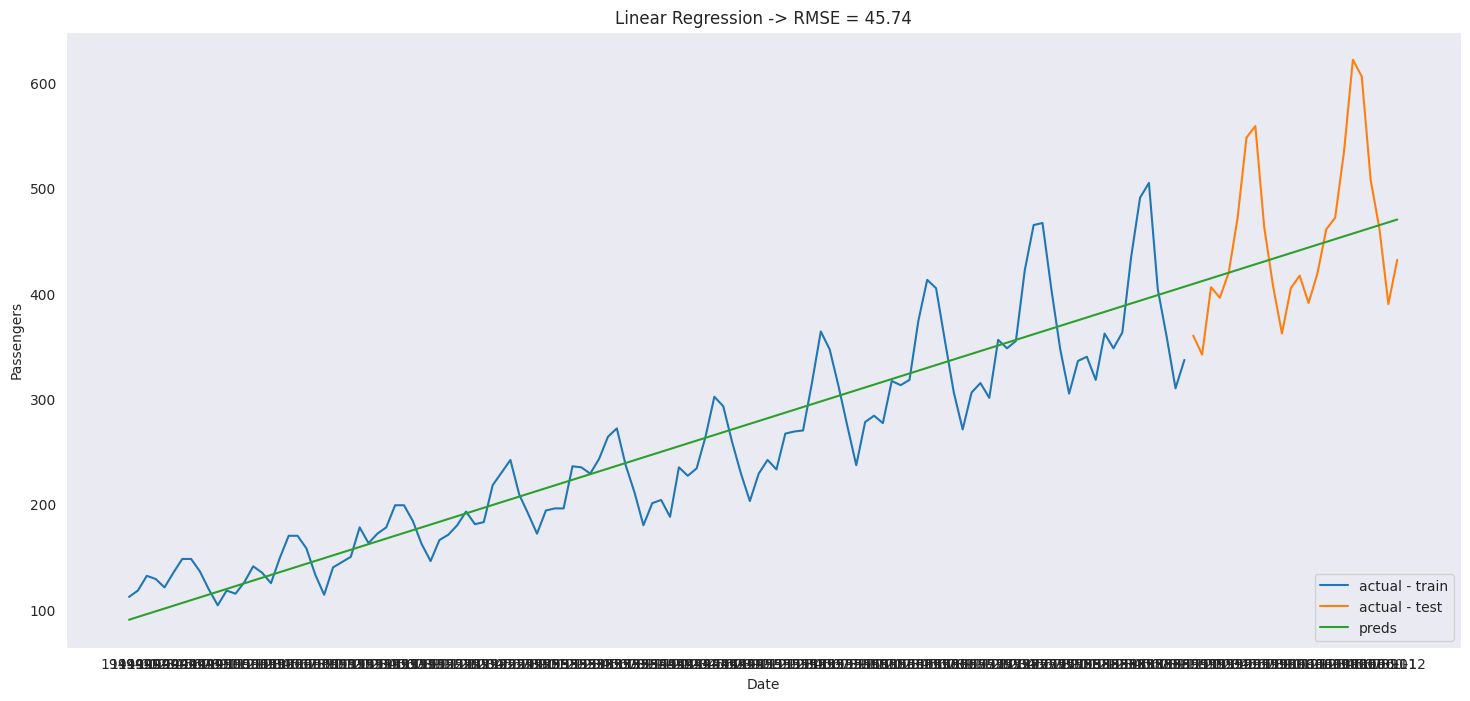

In [177]:
X = X = np.column_stack((np.ones(len(df['Passengers'])), range(len(df['Passengers']))))
model = sm.OLS(df['Passengers'], X).fit()

# make predictions using the fitted model
preds = model.predict(X)

# calculate the RMSE of the predictions
rmse = mean_squared_error(df['Passengers'], preds, squared=False)

plots(df['Passengers'],preds,f"Linear Regression -> RMSE = {round(rmse,2)}")


In [178]:
# multiple train test splits

n_splits = 5
ts = df['Passengers']

tscv = TimeSeriesSplit(n_splits=n_splits)
actuals = np.array([])
preds = np.array([])

# loop through each split and fit the OLS model and make predictions
for train_index, test_index in tscv.split(ts):
    # split the time series data into train and test sets
    train_data = ts[train_index]
    test_data = ts[test_index]

    # create the design matrix for the OLS model
    X_train = np.column_stack((np.ones(len(train_data)), range(len(train_data))))

    # fit the OLS model on the train data
    model = sm.OLS(train_data, X_train).fit()

    # make predictions on the test data
    X_test = np.column_stack((np.ones(len(test_data)), range(len(train_data), len(train_data) + len(test_data))))
    y_pred = model.predict(X_test)

    # store the actual and predicted values
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)

# calculate the RMSE of the predictions
rmse = mean_squared_error(actuals, preds, squared=False)

print('RMSE:', rmse)

RMSE: 53.389022042422255


In [179]:
# rolling forward evaluation

tscv = TimeSeriesSplit(test_size=1, n_splits=20, max_train_size=120)
actuals = np.array([])
preds = np.array([])

for train_index, test_index in tscv.split(df['Passengers']):
    train_X = np.column_stack((np.ones(len(train_index)), range(len(train_index))))
    train_y = df['Passengers'][train_index]
    test_X = np.column_stack((np.ones(len(test_index)), range(len(train_index), len(train_index) + len(test_index))))
    test_y = df['Passengers'][test_index]

    # fit the linear regression model on the training data
    model = sm.OLS(train_y, train_X).fit()

    # predict on the test data using the fitted model
    y_pred = model.predict(test_X)

    # store the actual and predicted values
    actuals = np.append(actuals, test_y)
    preds = np.append(preds, y_pred)

# calculate the RMSE of the predictions
rmse = mean_squared_error(actuals, preds, squared=False)
print('rolling forward RMSE:', rmse)

rolling forward RMSE: 77.66793020778863


# 5. Classical Decomposition

<Figure size 1800x800 with 0 Axes>

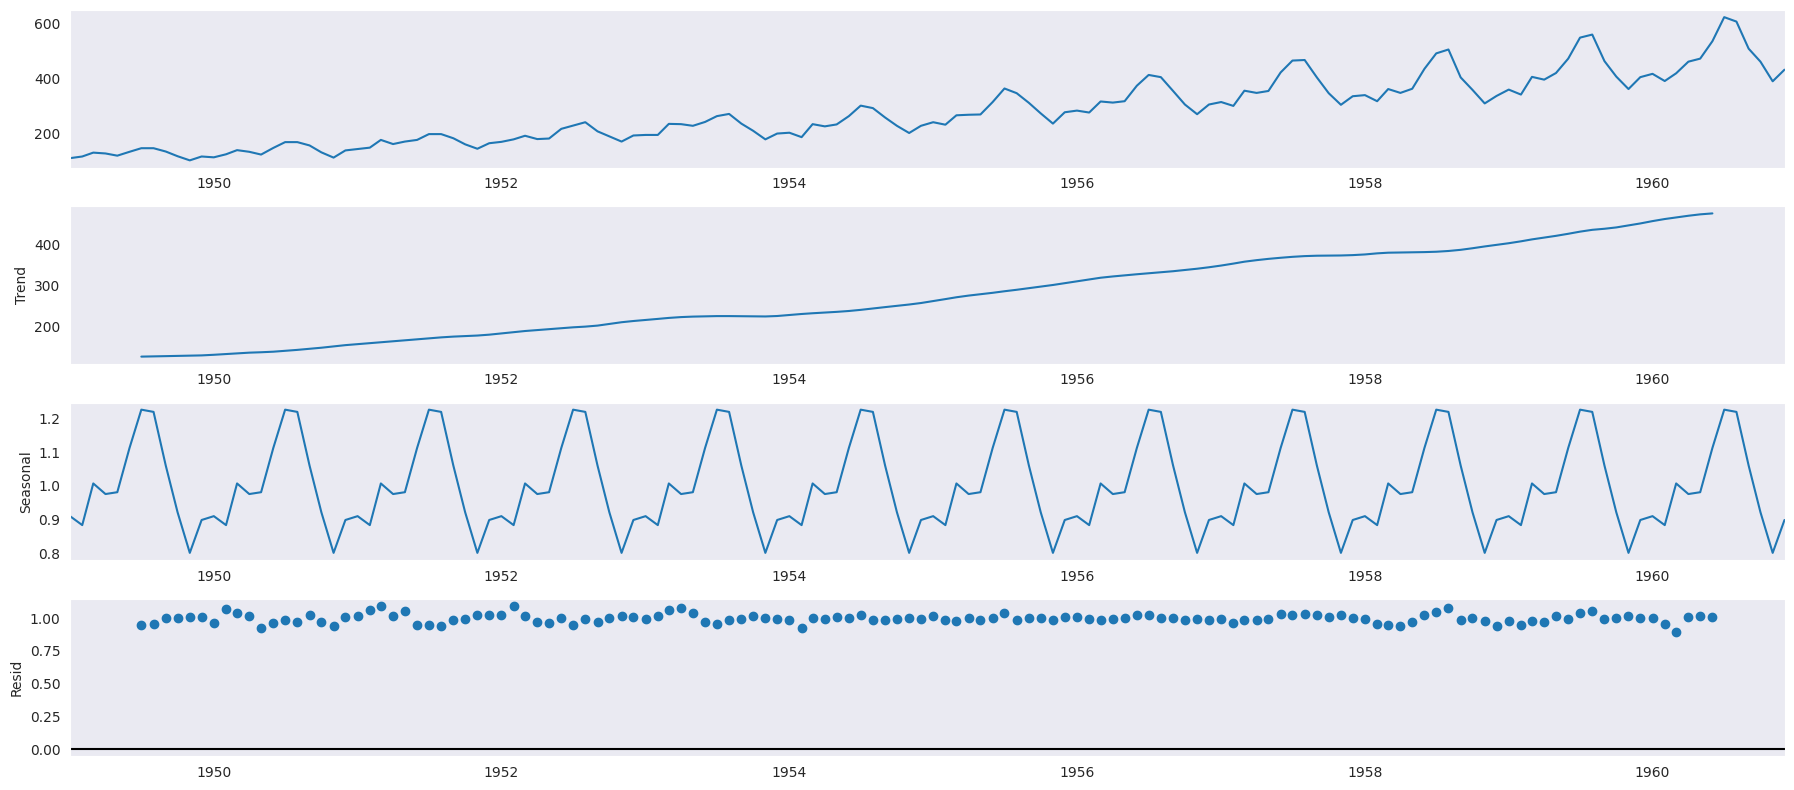

In [165]:
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(df2, model = 'multiplicative')
plt.figure(figsize = (18,8))
decomposition.plot()
plt.show()

# 6. STL Decomposition

In [2]:
77/4 , 18/16

(19.25, 1.125)

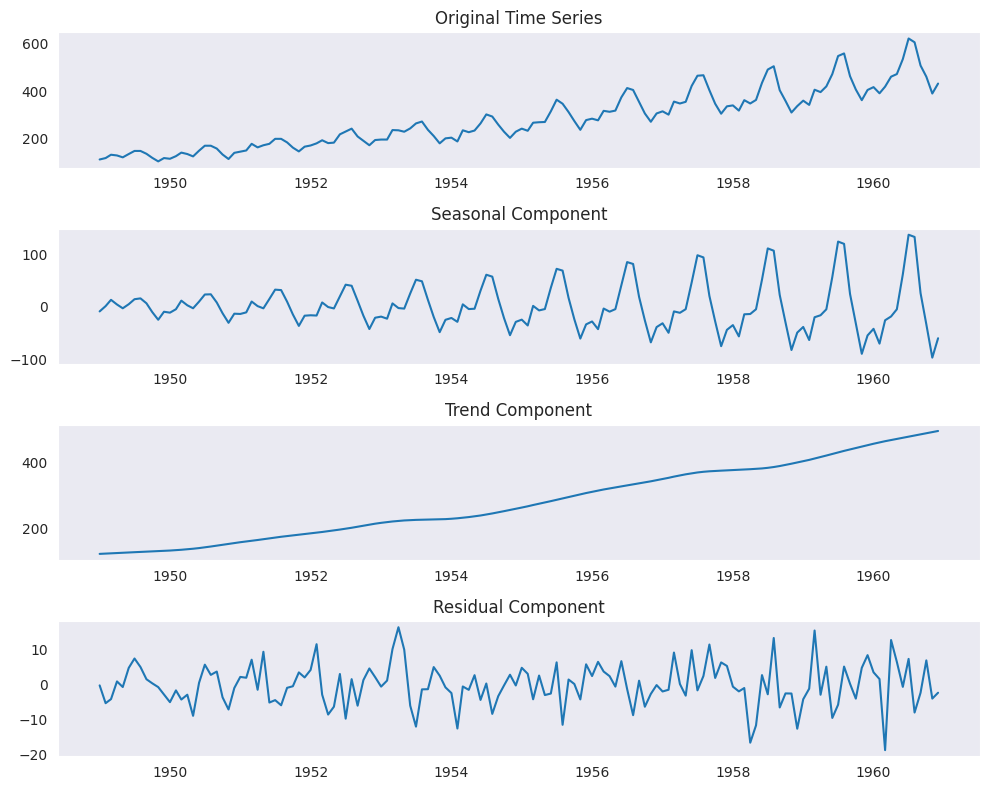

In [167]:
import pandas as pd
from statsmodels.tsa.seasonal import STL



# Perform STL decomposition on the passenger counts time series
stl = STL(df2, seasonal=13)  # seasonal parameter can be adjusted based on the seasonality of the data
result = stl.fit()

# Extract the seasonal, trend, and remainder components from the decomposition
seasonal, trend, residual = result.seasonal, result.trend, result.resid

# Plot the original time series and its components
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Original time series
ax[0].plot(df2)
ax[0].set_title('Original Time Series')

# Seasonal component
ax[1].plot(seasonal)
ax[1].set_title('Seasonal Component')

# Trend component
ax[2].plot(trend)
ax[2].set_title('Trend Component')

# Residual component
ax[3].plot(residual)
ax[3].set_title('Residual Component')

plt.tight_layout()
plt.show()

# 7. ARIMA/SARIMA models

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sb
sb.set_style("dark")
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


# function to apply for different arima/sarima models

In [ ]:
def Sarima_model(data,order,seasonal_order = None):
  SARIMA_model_1 = ARIMA(data, order=order, seasonal_order=seasonal_order)
  return SARIMA_model_1.fit()

In [ ]:
def Sarima_pipeline(data,evaluator,evaluator_param,order,seasonal_order = None):
  eval_str= str(evaluator)
  data_log = np.log(data)

  actuals,preds = evaluator(data_log,evaluator_param,Sarima_model,order,seasonal_order = seasonal_order)

  actuals = np.exp(actuals)
  preds = np.exp(preds)

  rmse = mean_squared_error(actuals, preds, squared=False)
  print(f"'{eval_str[10:26]}' RMSE: {rmse}")
  return actuals,preds

# evaluate using FIXED PARTITIONING

In [ ]:
def Fixed_forecast(data,train_size,model,order,seasonal_order = None):
  train_df = data.iloc[:train_size]
  actuals = data.iloc[train_size:]
  preds = model(train_df,order,seasonal_order = seasonal_order).predict(start=train_df.shape[0], end=(train_df.shape[0]+actuals.shape[0])-1)

  return actuals,preds

# evaluate using MULTIPLE SPLITS

In [ ]:
def tss_forecast(data,n_splits,model,order,seasonal_order = None):
  tscv = TimeSeriesSplit(n_splits=n_splits)

  actuals = np.array([])
  preds = np.array([])
  
  for train_index, test_index in tscv.split(data):
    train_data = data[train_index]
    test_data = data[test_index]
    y_pred = model(train_data,order,seasonal_order = seasonal_order).forecast(steps=len(test_data))
    
    actuals = np.append(actuals, test_data)
    preds = np.append(preds, y_pred)
  
  return actuals,preds

# evaluate using ROLL FORWARD

In [ ]:
def rolling_forecast_generator(data,window_size):
  for i in range(len(data)-window_size):
    yield data[:i+window_size]

def rolling_forecast(data,window_size,model,order,seasonal_order = None):
  actuals = data[window_size:]
  preds = np.array([model(train_data,order,seasonal_order = seasonal_order).forecast(steps=1) for train_data in rolling_forecast_generator(data,window_size)]).reshape(-1)
  return actuals,preds

# Visuallize the data 

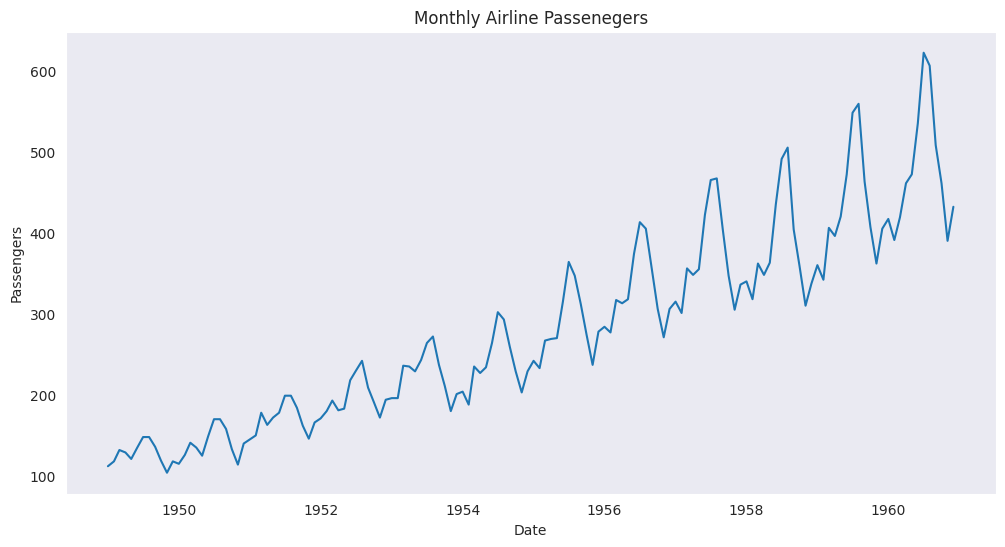

In [ ]:
plt.figure(figsize=(12,6));
plt.plot(df_copy.Month, df_copy.Passengers);
plt.xlabel('Date');
plt.ylabel('Passengers');
plt.title('Monthly Airline Passenegers');


After visuallizing the data we conlude that:

1) the data is not stationary at all

2) the variance is not constant

2) the data is seasonal

3) it contains an obvious upward trend


checking summary statistics by dividing the data to 4 quarters to check mean and variance

In [ ]:
x = df_copy['Passengers'].values
quarters = np.array_split(x, 4)

for i, quarter in enumerate(quarters):
    mean = np.mean(quarter)
    variance = np.var(quarter, ddof=1)
    print(f"Quarter {i+1}: Mean={mean:.2f}, Variance={variance:.2f}")

Quarter 1: Mean=145.50, Variance=622.20
Quarter 2: Mean=220.31, Variance=1116.33
Quarter 3: Mean=326.89, Variance=3553.93
Quarter 4: Mean=428.50, Variance=6293.11


we conclude that the mean and variance aren't constant 

we will do log transform before differncing as it requires the values to be positive and differncing can lead to negative values

# log transform

In [ ]:
df_copy['Passengers'] = np.log(df_copy['Passengers'])

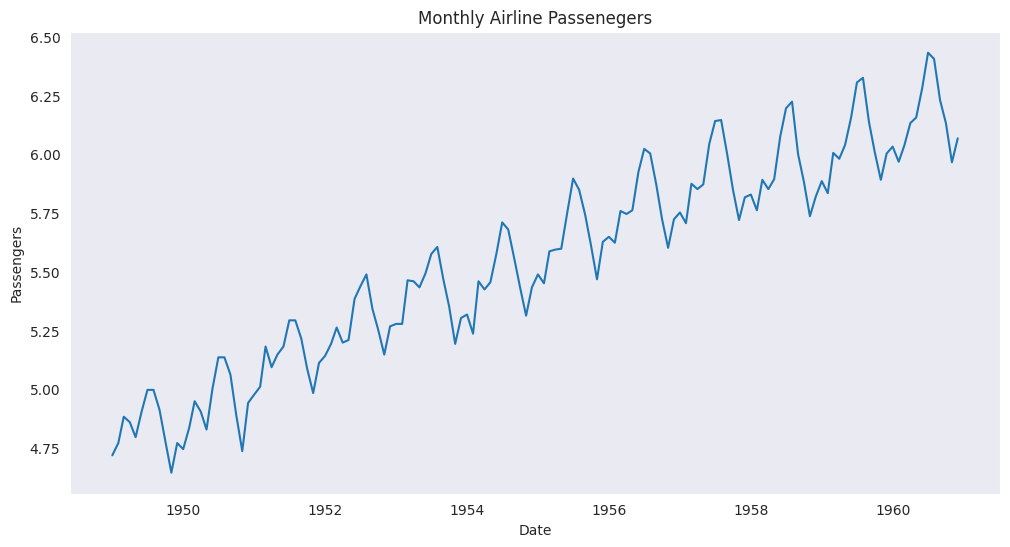

In [ ]:
plt.figure(figsize=(12,6));
plt.plot(df_copy.Month, df_copy.Passengers);
plt.xlabel('Date');
plt.ylabel('Passengers');
plt.title('Monthly Airline Passenegers');

# splitting the data 

In [ ]:
# we will split the data using fixed partioning to train the model 
# we will split the data into 10 years training(from 80-85 %) and two years testing

train_df = df_copy.iloc[:120]
test_df = df_copy.iloc[120:]

## then we will remove seasonality by applying one seasonal difference 

In [ ]:
# we will make a copy of the data as differncing if needed we can pass it as argument to ARIMA/SARIMA models

one_seasonal_difference = train_df.copy()

one_seasonal_difference['Passengers'] = train_df['Passengers'].diff(12)
one_seasonal_difference.dropna(inplace = True)

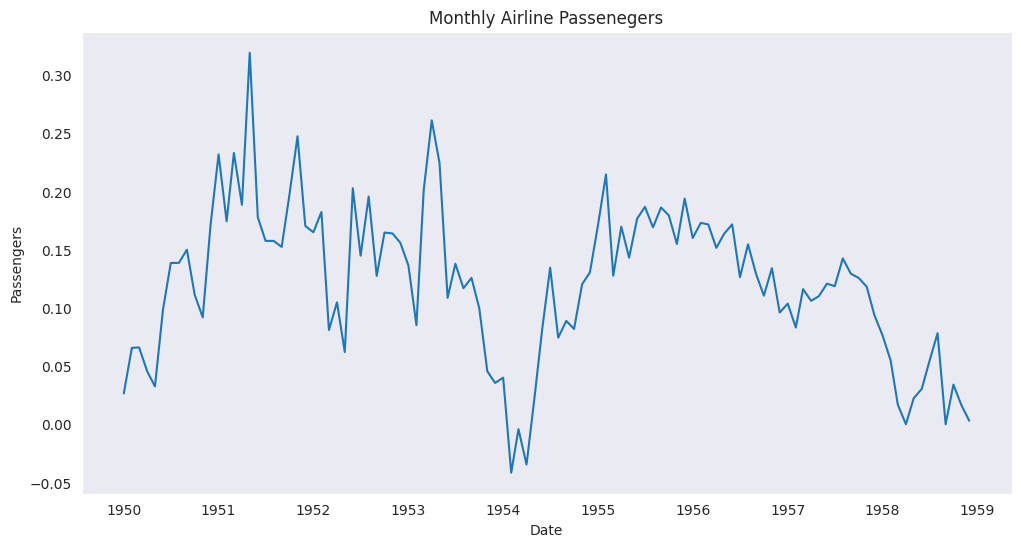

In [ ]:
plt.figure(figsize=(12,6));
plt.plot(one_seasonal_difference.Month, one_seasonal_difference.Passengers);
plt.xlabel('Date');
plt.ylabel('Passengers');
plt.title('Monthly Airline Passenegers');

# doing first difference to remove trend

In [ ]:
one_seasonal_difference['Passengers'] = one_seasonal_difference['Passengers'].diff(1)
one_seasonal_difference.dropna(inplace = True)

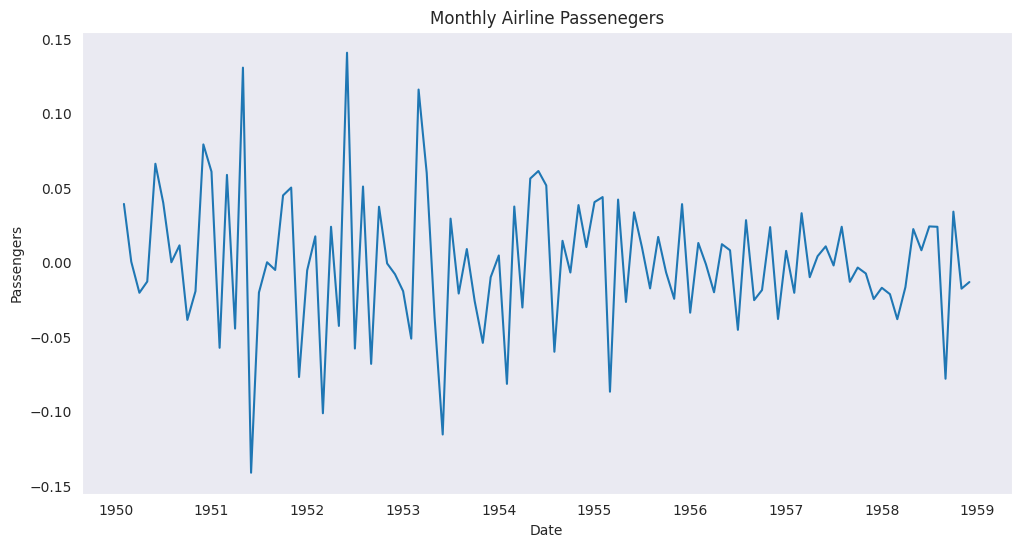

In [ ]:
plt.figure(figsize=(12,6));
plt.plot(one_seasonal_difference.Month, one_seasonal_difference.Passengers);
plt.xlabel('Date');
plt.ylabel('Passengers');
plt.title('Monthly Airline Passenegers');

# check stationarity using ADF test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(one_seasonal_difference['Passengers'])


In [ ]:
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -4.004616296917234
p-value: 0.001386530934090797


**As the p-value is too small so we reject the null hypothesis(the time series has no root ) and the data is stationary**

# ACF and PACF to determine the order of the model

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


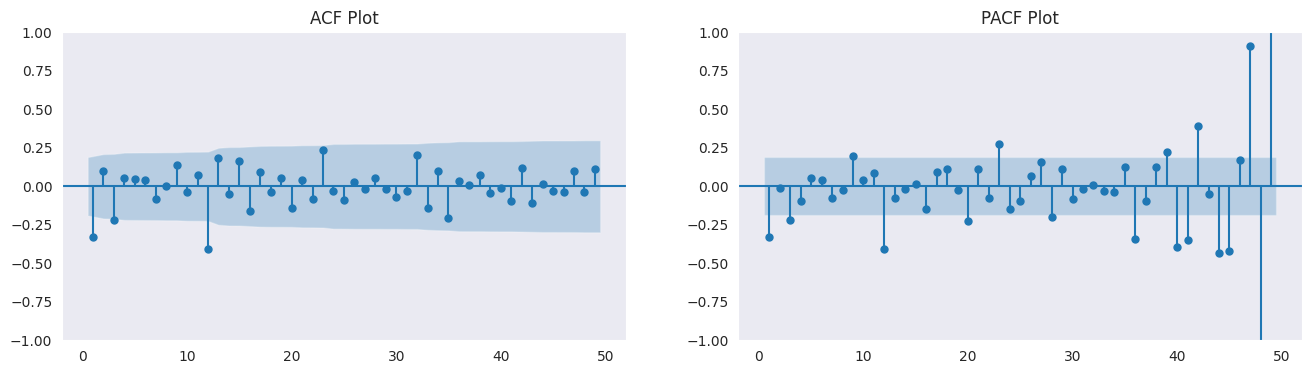

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(one_seasonal_difference['Passengers'], lags=range(1,50), ax=ax[0])
ax[0].set_title("ACF Plot")


plot_pacf(one_seasonal_difference['Passengers'], lags=range(1,50), ax=ax[1])
ax[1].set_title("PACF Plot")
plt.show()

### from the graphs we conclude that:
1) A decline after first lag in PACF indicate AR(1) component also,there is decline in ACF after first lag MA(1) we will check it

2) A decline after 12 lags in ACF indicate seasonal MA(1),also,there is decline in PACF after 12 lags seasonal AR(1) we will check it

so the best model is SARIMA(1,1,0)(0,1,1)12

we will try some other models like :

-SARIMA(1,1,0)(1,1,1)12

-SARIMA(1,1,1)(0,1,1)12

-SARIMA(1,1,1)(1,1,1)12

### first we will try AR(1) only 

In [ ]:
# model AR(1)

from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(train_df['Passengers'], order=(1,1,0))
model_fit_arima = ARIMA_model.fit()

# summary of fit model
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -563.328
Date:                Thu, 06 Apr 2023   AIC                           1130.656
Time:                        18:46:36   BIC                           1136.215
Sample:                             0   HQIC                          1132.913
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2858      0.093      3.074      0.002       0.104       0.468
sigma2       756.7940     80.855      9.360      0.000     598.321     915.267
Ljung-Box (L1) (Q):                   0.47   Jarque-

In [ ]:
# evaluate fixed 
Sarima_pipeline(df['Passengers'].copy(),Fixed_forecast,120,order = (1,1,0));

# multiple splits
Sarima_pipeline(df['Passengers'].copy(),tss_forecast,5,order = (1,1,0));

# roll forward
Sarima_pipeline(df['Passengers'].copy(),rolling_forecast,120,order = (1,1,0));

'Fixed_forecast a' RMSE: 131.84236781595723
'tss_forecast at ' RMSE: 85.348023194375
'rolling_forecast' RMSE: 49.4606823449027


MA(1) 

In [ ]:
# model MA(1)

from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(train_df['Passengers'], order=(0,1,1))
model_fit_arima = ARIMA_model.fit()

# summary of fit model
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -561.510
Date:                Thu, 06 Apr 2023   AIC                           1127.020
Time:                        19:12:06   BIC                           1132.578
Sample:                             0   HQIC                          1129.277
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3824      0.094      4.076      0.000       0.199       0.566
sigma2       733.5500     81.729      8.975      0.000     573.364     893.736
Ljung-Box (L1) (Q):                   0.09   Jarque-

In [ ]:
# evaluate fixed 
Sarima_pipeline(df['Passengers'].copy(),Fixed_forecast,120,order = (0,1,1));

# multiple splits
Sarima_pipeline(df['Passengers'].copy(),tss_forecast,5,order = (0,1,1));

# roll forward
Sarima_pipeline(df['Passengers'].copy(),rolling_forecast,120,order = (0,1,1));

'Fixed_forecast a' RMSE: 128.53091761485078
'tss_forecast at ' RMSE: 82.653982109578
'rolling_forecast' RMSE: 48.5400235737263


as we can see AR and MA alone performed terribly that is because we didn't account for seasonality

# ARIMA model

we will try to combine ar and ma using arima

In [ ]:
# model ARIMA(1,1,1)


ARIMA_model = ARIMA(train_df['Passengers'], order=(1,1,1))
model_fit_arima = ARIMA_model.fit()

# summary of fit model
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -563.328
Date:                Thu, 06 Apr 2023   AIC                           1130.656
Time:                        19:13:41   BIC                           1136.215
Sample:                             0   HQIC                          1132.913
                                - 120                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2858      0.093      3.074      0.002       0.104       0.468
sigma2       756.7940     80.855      9.360      0.000     598.321     915.267
Ljung-Box (L1) (Q):                   0.47   Jarque-

In [ ]:
# evaluate fixed 
Sarima_pipeline(df['Passengers'].copy(),Fixed_forecast,120,order = (1,1,1));

# multiple splits
Sarima_pipeline(df['Passengers'].copy(),tss_forecast,5,order = (1,1,1));

# roll forward
Sarima_pipeline(df['Passengers'].copy(),rolling_forecast,120,order = (1,1,1));

'Fixed_forecast a' RMSE: 126.15526614217293
'tss_forecast at ' RMSE: 83.16107789727943


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


'rolling_forecast' RMSE: 47.74524485082683


##again the model performed terribly as there is no account for seasonality so we will try SARIMA

# SARIMA model

In [ ]:
# we use seasonal differnce and first differnce
# model SARIMA(1,1,0)(0,1,1)12
from statsmodels.tsa.statespace.sarimax import SARIMAX


SARIMA_model_1 = SARIMAX(train_df['Passengers'], order=(1,1,0), seasonal_order=(0,1,1,12))
model_fit_1 = SARIMA_model_1.fit()

# summary of fit model
print(model_fit_1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -399.522
Date:                              Thu, 06 Apr 2023   AIC                            805.044
Time:                                      19:19:16   BIC                            813.062
Sample:                                           0   HQIC                           808.294
                                              - 120                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2320      0.092     -2.523      0.012      -0.412      -0.052
ma.S.L12      -0.04

In [ ]:
# model SARIMA(1,1,0)(1,1,1)12

SARIMA_model_2 = SARIMAX(train_df['Passengers'], order=(1,1,0), seasonal_order=(1,1,1,12))
model_fit_2 = SARIMA_model_2.fit()

# summary of fit model
print(model_fit_2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -399.002
Date:                              Thu, 06 Apr 2023   AIC                            806.005
Time:                                      19:20:09   BIC                            816.696
Sample:                                           0   HQIC                           810.339
                                              - 120                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2551      0.092     -2.759      0.006      -0.436      -0.074
ar.S.L12      -0.99

In [ ]:
# model SARIMA(1,1,1)(0,1,1)12

SARIMA_model_3 = SARIMAX(train_df['Passengers'], order=(1,1,1), seasonal_order=(0,1,1,12))
model_fit_3= SARIMA_model_3.fit()

# summary of fit model
print(model_fit_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -399.285
Date:                            Thu, 06 Apr 2023   AIC                            806.570
Time:                                    19:20:16   BIC                            817.261
Sample:                                         0   HQIC                           810.904
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5131      0.382     -1.343      0.179      -1.262       0.236
ma.L1          0.3009      0.405   

In [ ]:
# model SARIMA(1,1,1)(1,1,1)12

SARIMA_model_4 = SARIMAX(train_df['Passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_4= SARIMA_model_4.fit()

# summary of fit model
print(model_fit_4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -398.830
Date:                            Thu, 06 Apr 2023   AIC                            807.660
Time:                                    19:20:24   BIC                            821.024
Sample:                                         0   HQIC                           813.078
                                            - 120                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4901      0.351     -1.397      0.162      -1.178       0.197
ma.L1          0.2579      0.373   

## we conclude after trying many variations of the model that 
## SARIMA(1,1,0)(0,1,1)12  has the lowest AIC we choose it

### check the residuals

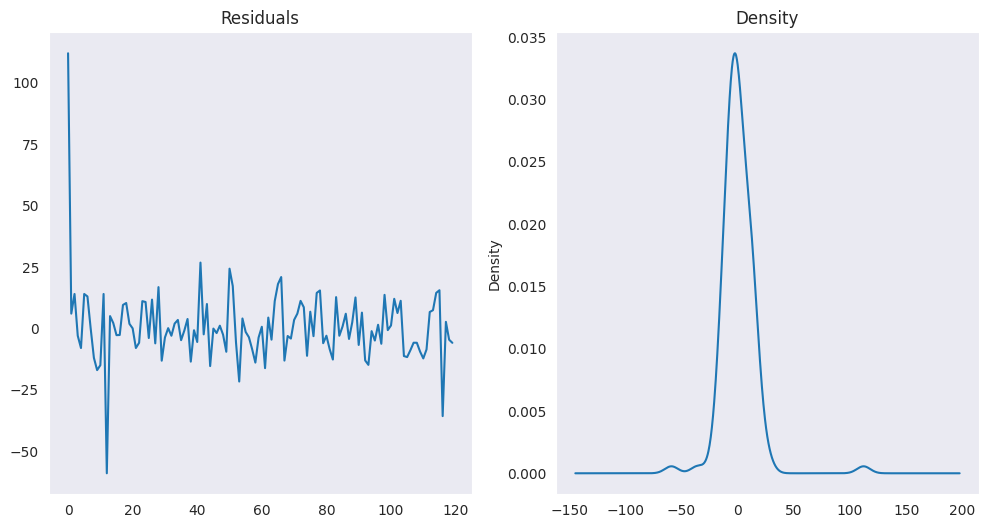

In [ ]:
residuals = model_fit_1.resid
fig, ax = plt.subplots(1,2);
residuals.plot(title='Residuals', ax=ax[0], figsize=(12,6));
residuals.plot(title='Density', kind='kde', ax=ax[1]);

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


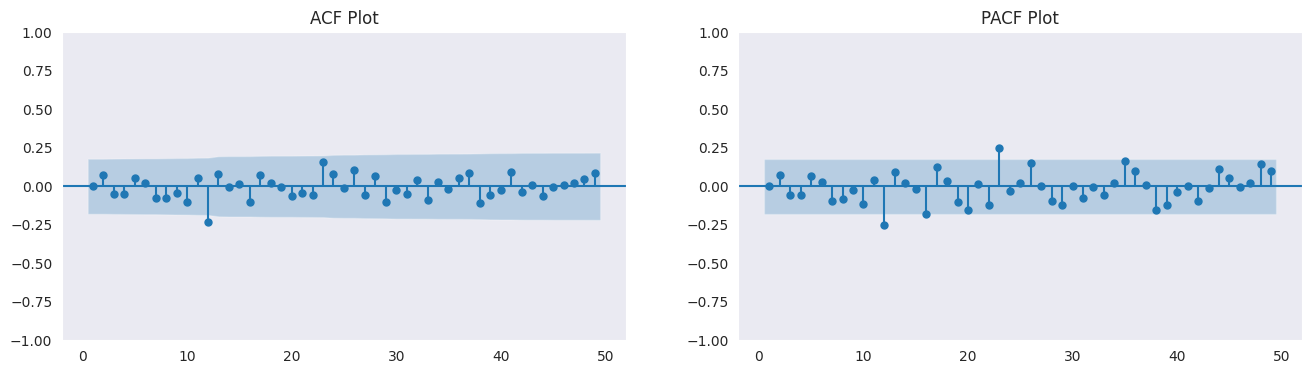

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(residuals, lags=range(1,50), ax=ax[0])
ax[0].set_title("ACF Plot")


plot_pacf(residuals, lags=range(1,50), ax=ax[1])
ax[1].set_title("PACF Plot")
plt.show()

As we can see there is no significant spike

# Evaluate the model

In [ ]:
# evaluate fixed 
actuals_fixed,preds_fixed = Sarima_pipeline(df['Passengers'].copy(),Fixed_forecast,120,order = (1,1,0),seasonal_order = (0,1,1,12));

# multiple splits
actuals_multiple,preds_multiple = Sarima_pipeline(df['Passengers'].copy(),tss_forecast,5,order = (1,1,0),seasonal_order = (0,1,1,12));

# roll forward
actuals_roll,preds_roll = Sarima_pipeline(df['Passengers'].copy(),rolling_forecast,120,order = (1,1,0),seasonal_order = (0,1,1,12));

'Fixed_forecast a' RMSE: 45.51890277696671
'tss_forecast at ' RMSE: 28.186382890100724
'rolling_forecast' RMSE: 15.832967018770454


##we notice that arima model give better results using roll forward.
##that is because arima model rely on sequential data and when it is used to predict large amount of data(fixed partioning and multiple splits ) it uses its predictions to make another predictions which can lead to a bad results.

##unlike roll forward approach which predicts only one observation and use actual data to predict it which increases its performance
## that also mimic how the model work on real life as we use historical data to predict the next observation then add that observation to the data and so on.

# visualize prediction

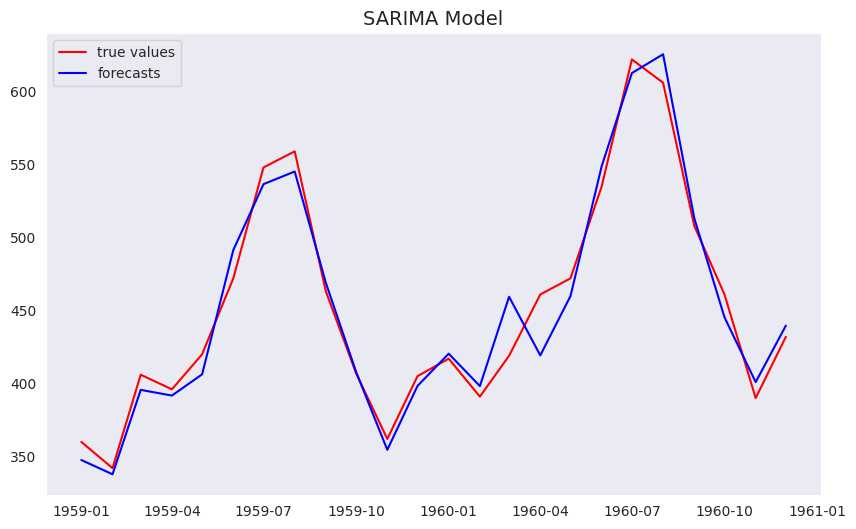

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(test_df.Month,actuals_roll, label = "true values", color = "red")
plt.plot(test_df.Month,preds_roll,label = "forecasts", color='blue')
plt.title("SARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

# 8. Facebook prophet

In [168]:
def model_pipeline(data,evaluator,evaluator_param):
  data_log = np.log(data)

  actuals,preds = evaluator(data_log,evaluator_param,Sarima_model)

  actuals = np.exp(actuals)
  preds = np.exp(preds)

  rmse = mean_squared_error(actuals, preds, squared=False)
  print('Rolling forecast RMSE:', rmse)

In [ ]:
# Renaming columns to work with facebook prophet model.
facebook_prophet_df = df.copy()
facebook_prophet_df['Log_Passengers'] = np.log(facebook_prophet_df['Passengers'])
facebook_prophet_df= facebook_prophet_df.rename(columns={'Month':'ds','Log_Passengers':'y'})

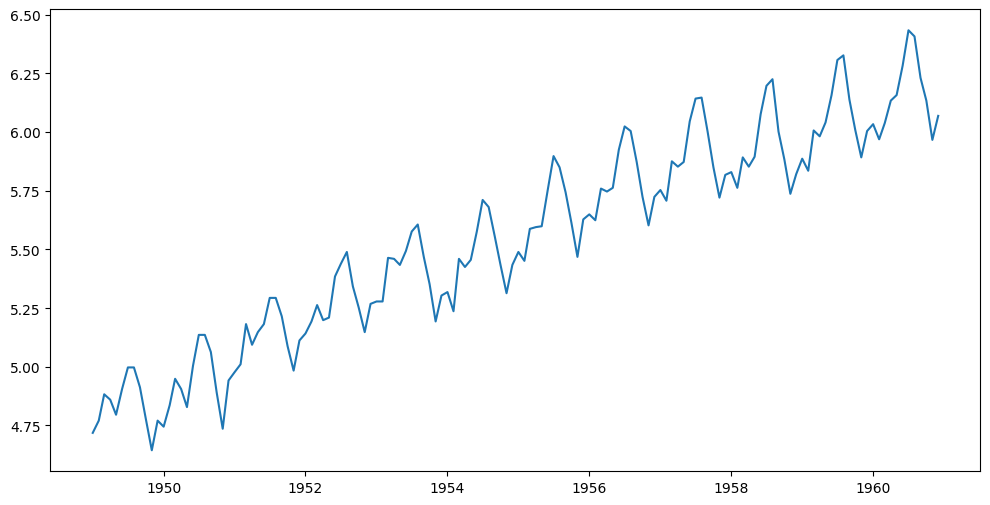

In [ ]:
# Visualizing data
plt.figure(figsize=(12,6))
plt.plot(facebook_prophet_df['ds'], facebook_prophet_df['y'] )
plt.show()

#Fixed Patitioning Evaluation

In [ ]:
# Fixed Patitioning Forecast.
prophet_model = prophet.Prophet()
prophet_model.fit(facebook_prophet_df.iloc[:120])

15:10:29 - cmdstanpy - INFO - Chain [1] start processing
15:10:29 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Forecasting.
facebook_prophet_forecast = prophet_model.predict(facebook_prophet_df)
# Root mean square error in Fixed partionning Evaluation after reversing log.
"rmse using fixed partionning Evaluation = " + f'{mean_squared_error(facebook_prophet_df.Passengers, np.exp(facebook_prophet_forecast.yhat),squared=False)}'

'rmse using fixed partionning Evaluation = 18.056533258818966'

In [ ]:
# Visualizing Facebook prophet model results.
facebook_prophet = prophet.plot.plot_plotly(prophet_model,facebook_prophet_forecast)
facebook_prophet.update_xaxes(title='Time').update_yaxes(title='Log Passengers').update_layout(showlegend=True)
facebook_prophet

### <font color='red'/> ___Time Series Cross-Validator Evaluation (Expanding):___

In [ ]:
# Time series cross-validation Evaluation .
tscv = TimeSeriesSplit(n_splits=5,test_size=12) # Test Window size = 12
actuals = np.array([]) 
preds = np.array([])
for train_index, test_index in tscv.split(facebook_prophet_df):     # Getting indices.
    # Getting train-test data.
    train_data = facebook_prophet_df.iloc[train_index]
    test_data = facebook_prophet_df.iloc[test_index]
    
    # Fitting and Predicting.
    prophet_model = prophet.Prophet()
    prophet_model.fit(train_data)
    y_pred = prophet_model.predict(test_data)
    
    # Saving for evaluation.
    actuals = np.append(actuals,test_data['Passengers']) # Saving Actual Data 
    preds = np.append(preds, np.exp(y_pred['yhat']) ) # Saving Predicitions

15:10:29 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing
15:10:30 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing
15:10:30 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing
15:10:30 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing
15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Root mean square error in Time Series Split Evaluation after reversing log.
"rmse using Time Series cross-validation Evaluation (Expanding) (test window size = 12) = " + f'{mean_squared_error(actuals, preds,squared=False)}'

'rmse using Time Series cross-validation Evaluation (Expanding) (test window size = 12) = 27.78494480828524'

In [ ]:
# Time series cross-validation Evaluation .
tscv = TimeSeriesSplit(n_splits=5,test_size=24) # Test Window size = 24
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(facebook_prophet_df):     # Getting indices.
    # Getting train-test data.
    train_data = facebook_prophet_df.iloc[train_index]
    test_data = facebook_prophet_df.iloc[test_index]
    
    # Fitting and Predicting.
    prophet_model = prophet.Prophet()
    prophet_model.fit(train_data)
    y_pred = prophet_model.predict(test_data)
    
    # Saving for evaluation.
    actuals = np.append(actuals,test_data['Passengers'])
    preds = np.append(preds, np.exp(y_pred['yhat']) )

15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing
15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:31 - cmdstanpy - INFO - Chain [1] done processing
15:10:31 - cmdstanpy - INFO - Chain [1] start processing
15:10:32 - cmdstanpy - INFO - Chain [1] done processing
15:10:32 - cmdstanpy - INFO - Chain [1] start processing
15:10:32 - cmdstanpy - INFO - Chain [1] done processing
15:10:32 - cmdstanpy - INFO - Chain [1] start processing
15:10:33 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Root mean square error in Time Series Split Evaluation after reversing log.
"rmse using Time series cross-validation Evaluation (Expanding) (test window size = 24) = " + f'{mean_squared_error(actuals, preds,squared=False)}'

'rmse using Time series cross-validation Evaluation (Expanding) (test window size = 24) = 38.72562801814075'

##### <font color='blue'/>__Notice : The More I increase the size of the test window the more the RMSE increases.__

### <font color='red'/> ___Time Series Cross-Validator Evaluation (Sliding):___

In [ ]:
# Time series cross-validation Evaluation .
tscv = TimeSeriesSplit(n_splits=4,test_size=12,max_train_size=24) # Test Window size = 12
actuals = np.array([]) 
preds = np.array([])
for train_index, test_index in tscv.split(facebook_prophet_df):     # Getting indices.
    # Getting train-test data.
    train_data = facebook_prophet_df.iloc[train_index]
    test_data = facebook_prophet_df.iloc[test_index]
    
    # Fitting and Predicting.
    prophet_model = prophet.Prophet()
    prophet_model.fit(train_data)
    y_pred = prophet_model.predict(test_data)
    
    # Saving for evaluation.
    actuals = np.append(actuals,test_data['Passengers']) # Saving Actual Data 
    preds = np.append(preds, np.exp(y_pred['yhat']) ) # Saving Predicitions

15:10:33 - cmdstanpy - INFO - Chain [1] start processing
15:10:33 - cmdstanpy - INFO - Chain [1] done processing
15:10:33 - cmdstanpy - INFO - Chain [1] start processing
15:10:33 - cmdstanpy - INFO - Chain [1] done processing
15:10:33 - cmdstanpy - INFO - Chain [1] start processing
15:10:33 - cmdstanpy - INFO - Chain [1] done processing
15:10:33 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Root mean square error in Time Series Split Evaluation after reversing log.
"rmse using Time Series Split Evaluation (Sliding)= " + f'{mean_squared_error(actuals, preds,squared=False)}'

'rmse using Time Series Split Evaluation (Sliding)= 67.2807207180604'

### <font color='red'/> ___Roll-Forward Evaluation (Expanding) :___

In [ ]:
# Roll-Forward Evaluation .
tscv = TimeSeriesSplit(n_splits=24,test_size=1) # Test Window size = 24
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(facebook_prophet_df):     # Getting indices.
    # Getting train-test data.
    train_data = facebook_prophet_df.iloc[train_index]
    test_data = facebook_prophet_df.iloc[test_index]
    
    # Predicting.
    prophet_model = prophet.Prophet()
    prophet_model.fit(train_data)
    y_pred = prophet_model.predict(test_data)
    
    # Saving for evaluation.
    actuals = np.append(actuals,test_data['Passengers'])
    preds = np.append(preds, np.exp(y_pred['yhat']) )

15:10:34 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing
15:10:34 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing
15:10:34 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing
15:10:34 - cmdstanpy - INFO - Chain [1] start processing
15:10:34 - cmdstanpy - INFO - Chain [1] done processing
15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing
15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing
15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing
15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1] done processing
15:10:35 - cmdstanpy - INFO - Chain [1] start processing
15:10:35 - cmdstanpy - INFO - Chain [1]

In [ ]:
# Root mean square error in Roll-Forward Evaluation after reversing log.
"rmse using Roll-Forward Evaluation = " + f'{mean_squared_error(actuals, preds,squared=False)}'

'rmse using Roll-Forward Evaluation = 26.679892504236793'

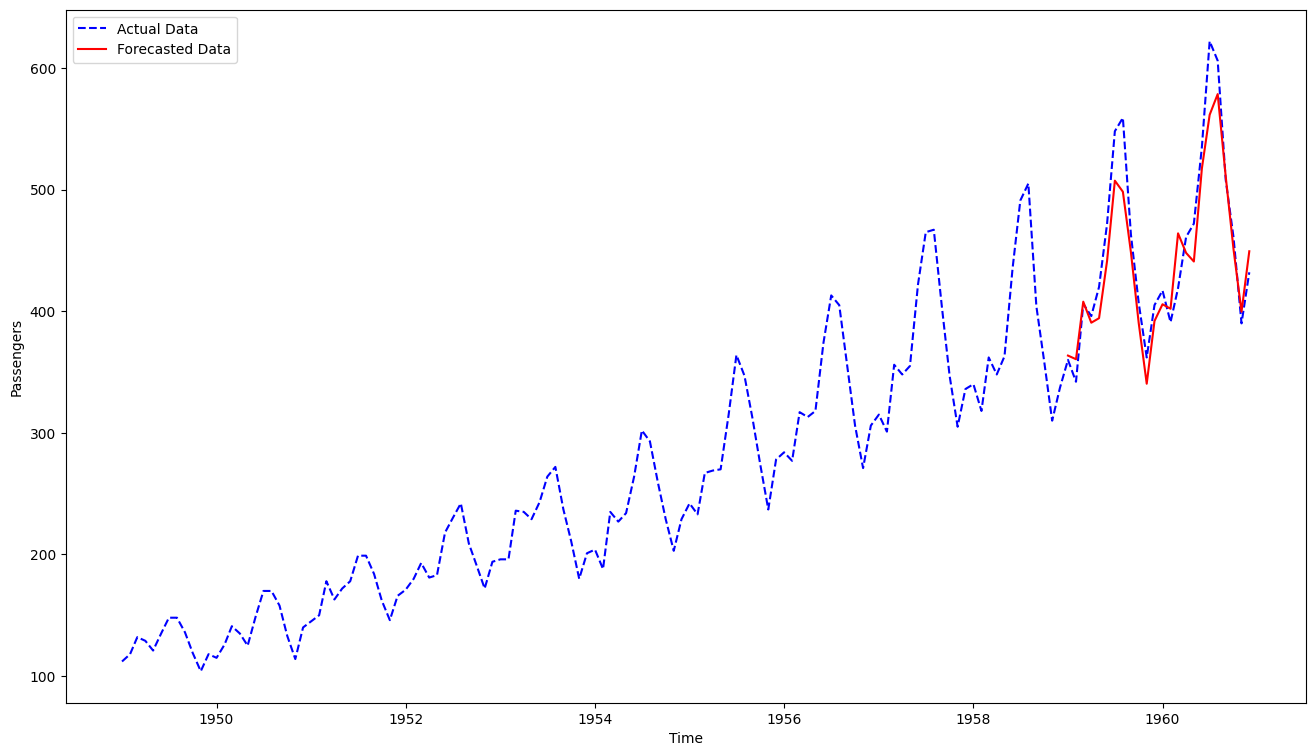

In [ ]:
# Visualizing Facebook prophet model results after reversing the log.
plt.figure(figsize=(16,9))
plt.plot(facebook_prophet_df['ds'],facebook_prophet_df['Passengers'],'--b' )
plt.plot(facebook_prophet_df['ds'].iloc[120:],preds ,'r' )
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend(['Actual Data','Forecasted Data'],loc='upper left')
plt.show()

### <font color='red'/> ___Roll-Forward Evaluation (Sliding) :___

In [ ]:
# Roll-Forward Evaluation .
tscv = TimeSeriesSplit(n_splits=120,test_size=1,max_train_size=24) # Test Window size = 24
actuals = np.array([])
preds = np.array([])
for train_index, test_index in tscv.split(facebook_prophet_df):     # Getting indices.
    # Getting train-test data.
    train_data = facebook_prophet_df.iloc[train_index]
    test_data = facebook_prophet_df.iloc[test_index]
    
    # Predicting.
    prophet_model = prophet.Prophet()
    prophet_model.fit(train_data)
    y_pred = prophet_model.predict(test_data)
    
    # Saving for evaluation.
    actuals = np.append(actuals,test_data['Passengers'])
    preds = np.append(preds, np.exp(y_pred['yhat']) )

15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:39 - cmdstanpy - INFO - Chain [1] done processing
15:10:39 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:40 - cmdstanpy - INFO - Chain [1] done processing
15:10:40 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1] done processing
15:10:41 - cmdstanpy - INFO - Chain [1] start processing
15:10:41 - cmdstanpy - INFO - Chain [1]

In [ ]:
# Root mean square error in Roll-Forward Evaluation after reversing log.
"rmse using Roll-Forward Evaluation (Sliding) = " + f'{mean_squared_error(actuals, preds,squared=False)}'

'rmse using Roll-Forward Evaluation (Sliding) = 56.42625115612806'

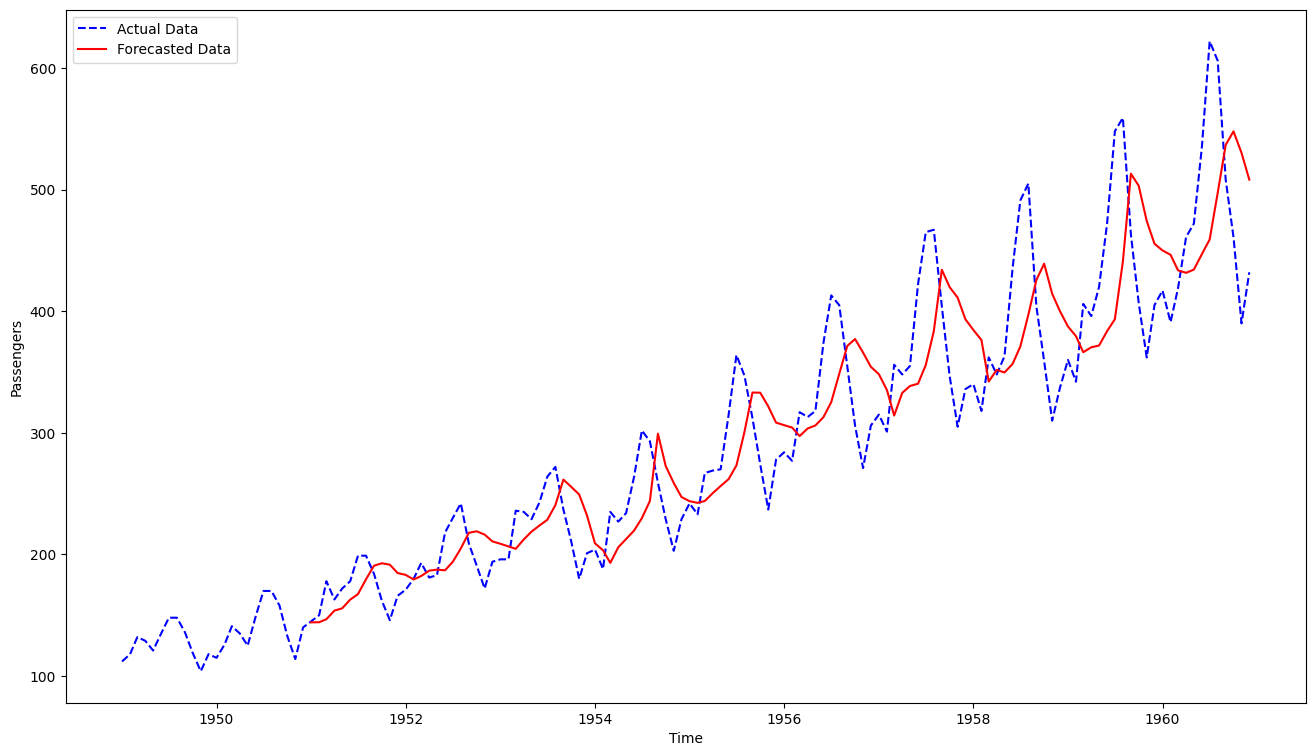

In [ ]:
# Visualizing Facebook prophet model results after reversing the log.
plt.figure(figsize=(16,9))
plt.plot(facebook_prophet_df['ds'],facebook_prophet_df['Passengers'],'--b' )
plt.plot(facebook_prophet_df['ds'].iloc[24:],preds ,'r' )
plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend(['Actual Data','Forecasted Data'],loc='upper left')
plt.show()

# Conclusion after using <font color='magneta'>__Facebook prophet__</font> : <br>
1-Facebook prophet is user-friendly and easy to use. <br>
2-The model detected trend and seasonality in data. <br>
3-The model gives us boundaries for each value it exports.<br>
4-In Facebook Prohpet best approach to train data with current dataset is Fixed Partioning <br>
5- Root Mean Square Error in Facebook Prophet Using : <br>
&emsp;&emsp;a-fixed partioning Evaluation = 18.056533258818966 <br>
&emsp;&emsp;b-Time Series cross-validation Evaluation (Expanding) (test window size = 12) = 27.78494480828524 <br>
&emsp;&emsp;c-Time series cross-validation Evaluation (Expanding) (test window size = 24) = 38.72562801814075 <br>
&emsp;&emsp;d-Time Series Split Evaluation (Sliding)= 67.2807207180604 <br>
&emsp;&emsp;e-Roll-Forward Evaluation (Expanding) = 26.679892504236793 <br>
&emsp;&emsp;f-Roll-Forward Evaluation (Sliding) = 56.42625115612806
***

<a id='single_exponential_smoothing'></a>
# 9. Predicting with <font color='magneta'/>__Single Exponential Smoothing :__

In [ ]:
# Loading model.
from statsmodels.tsa.api import SimpleExpSmoothing
def Simple_Exp_Smoothing(data) : 
    # Fitting simple exponential smoothing model.
    return SimpleExpSmoothing(data).fit(optimized=True) # optimized=True : Auto Optimization to find value of alpha (smoothing coefficient).

In [ ]:
model_pipeline(df['Passengers'].copy(),Fixed_forecast,120,Simple_Exp_Smoothing)

Fixed_forecast RMSE: 137.32898491091922


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = Fixed_forecast(np.log(df['Passengers'].copy()),120,Simple_Exp_Smoothing)

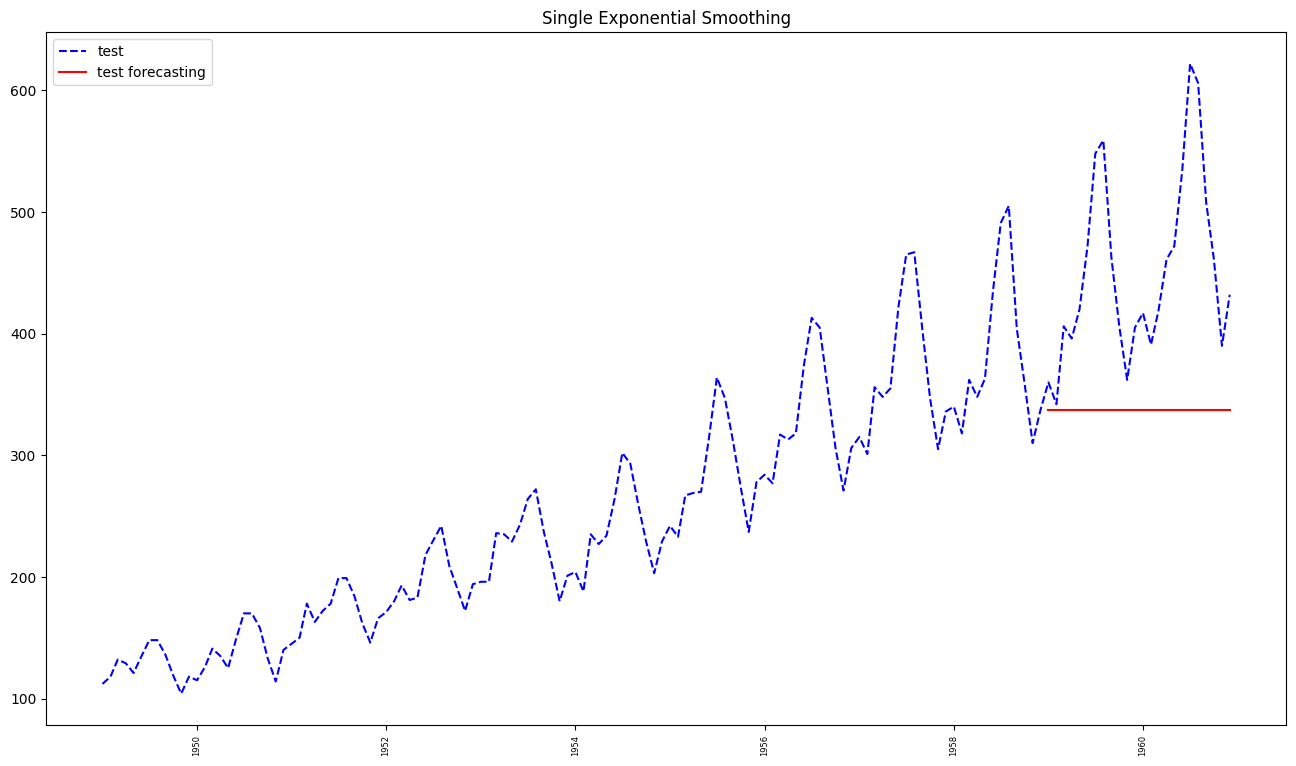

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),tss_forecast,5,Simple_Exp_Smoothing)

tss_forecast RMSE: 89.73595559564116


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = tss_forecast(np.log(df['Passengers'].copy()),5,Simple_Exp_Smoothing)

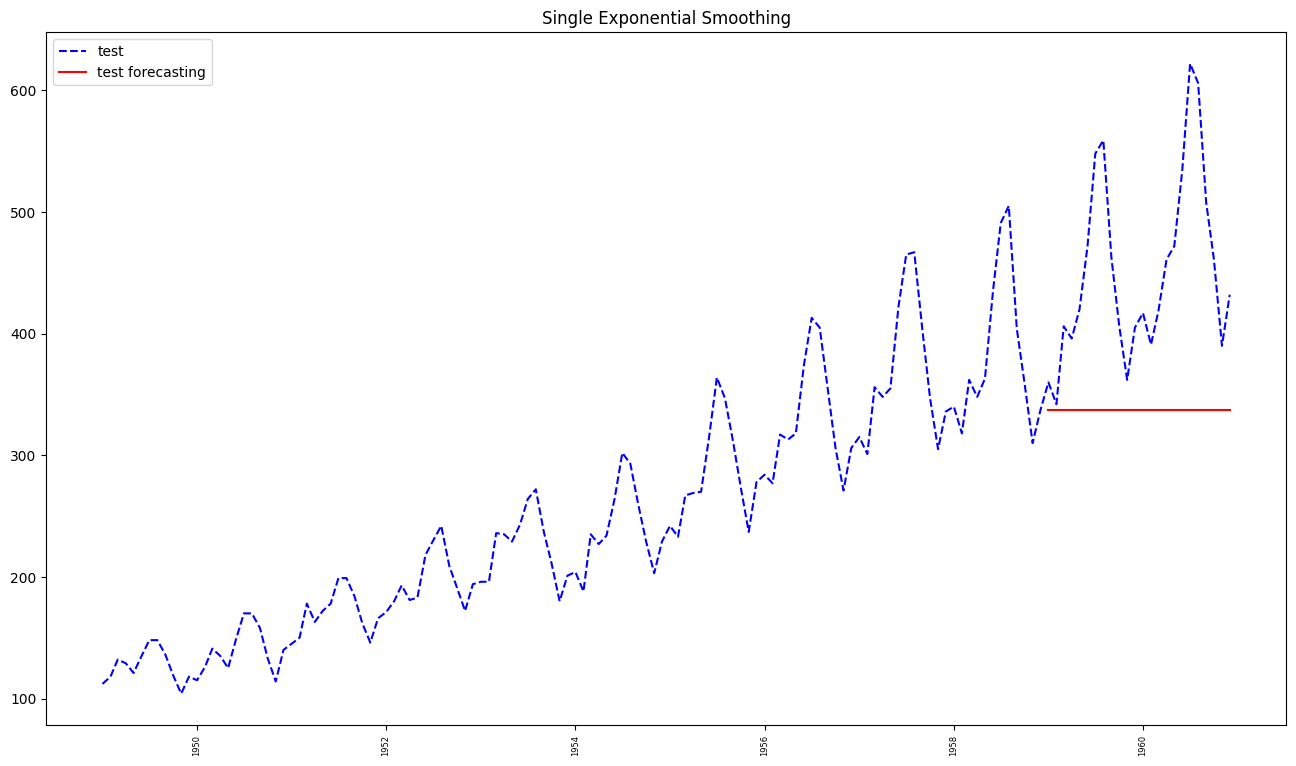

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[-24:],np.exp(test_preds[-24:]), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),rolling_forecast,120,Simple_Exp_Smoothing)

rolling_forecast RMSE: 51.78199519629349


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = rolling_forecast(np.log(df['Passengers'].copy()),120,Simple_Exp_Smoothing)

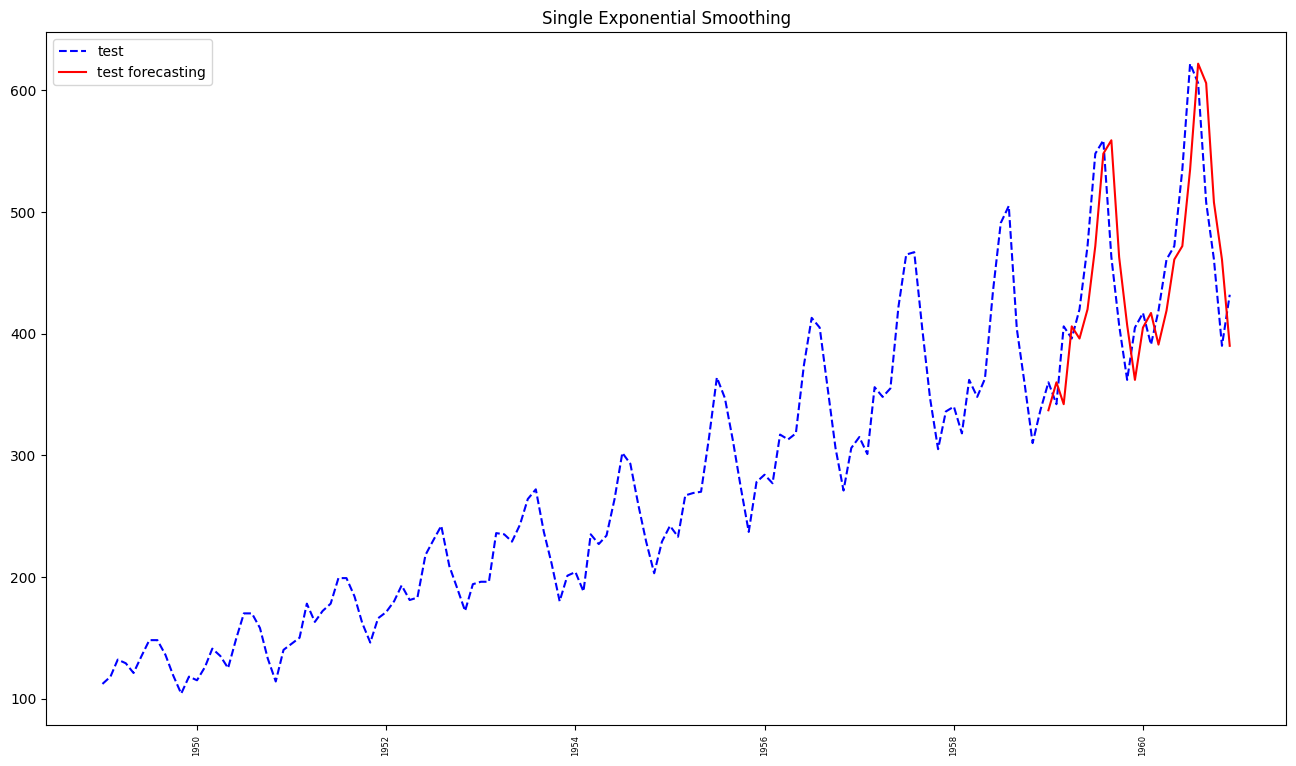

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Single Exponential Smoothing")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

### <font color='blue'/> ___Single smoothing predict only Levels but because of the rolling window it acted like the above curve.___

# Conclusion after using <font color='magneta'>__Single exponential smoothing :__</font>  <br>

1-Single exponential smoothing forecasts level only and ignored trend and seasonality. <br>
2-It predicted the value after the training data then applied : "F<sub>n+k</sub> = F<sub>n+1</sub>" . <br>
3-That means that it predicted only one level the took the rest of the predictions to be that level and that's why the forecasted values are close to the last value of training. <br>
4-All of above points explains the high mean square error of forecasted values. <br>
5-Rolling window approach is not acceptable in Single Exponential Smoothing.
***

<a id='Double_exponential_smoothing'></a>
# Predicting with <font color='magneta'/>__Double Exponential Smoothing :__

### <font color='red'/>__Without Damping :__

In [ ]:
# Loading model.
from statsmodels.tsa.api import Holt
def Double_Exp_Smoothing(data) : 
    # Fitting simple exponential smoothing model.
    return Holt(data).fit(optimized=True) # optimized=True : Auto Optimization to find value of alpha (smoothing coefficient).

In [ ]:
model_pipeline(df['Passengers'].copy(),Fixed_forecast,120,Double_Exp_Smoothing)

Fixed_forecast RMSE: 100.68093087404799


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = Fixed_forecast(np.log(df['Passengers'].copy()),120,Double_Exp_Smoothing)

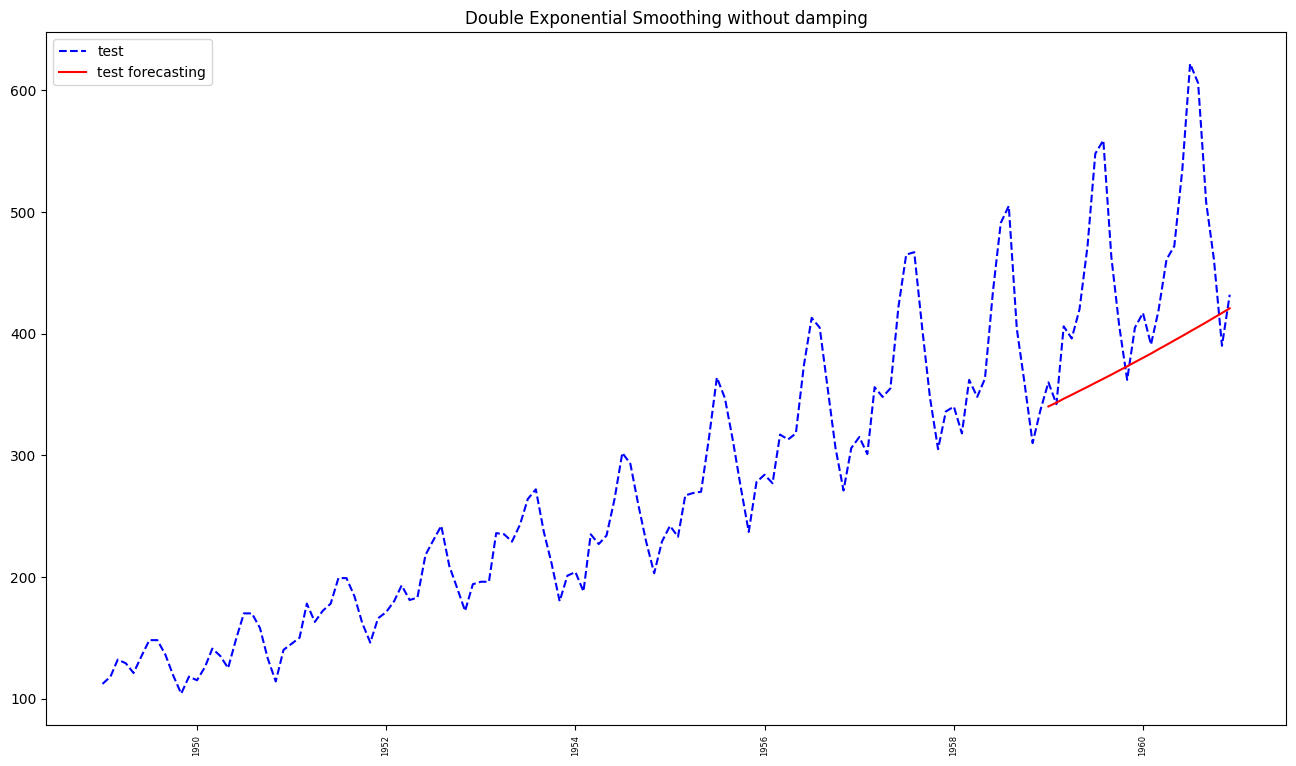

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),tss_forecast,5,Double_Exp_Smoothing)

tss_forecast RMSE: 63.84845876371863


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = tss_forecast(np.log(df['Passengers'].copy()),5,Double_Exp_Smoothing)

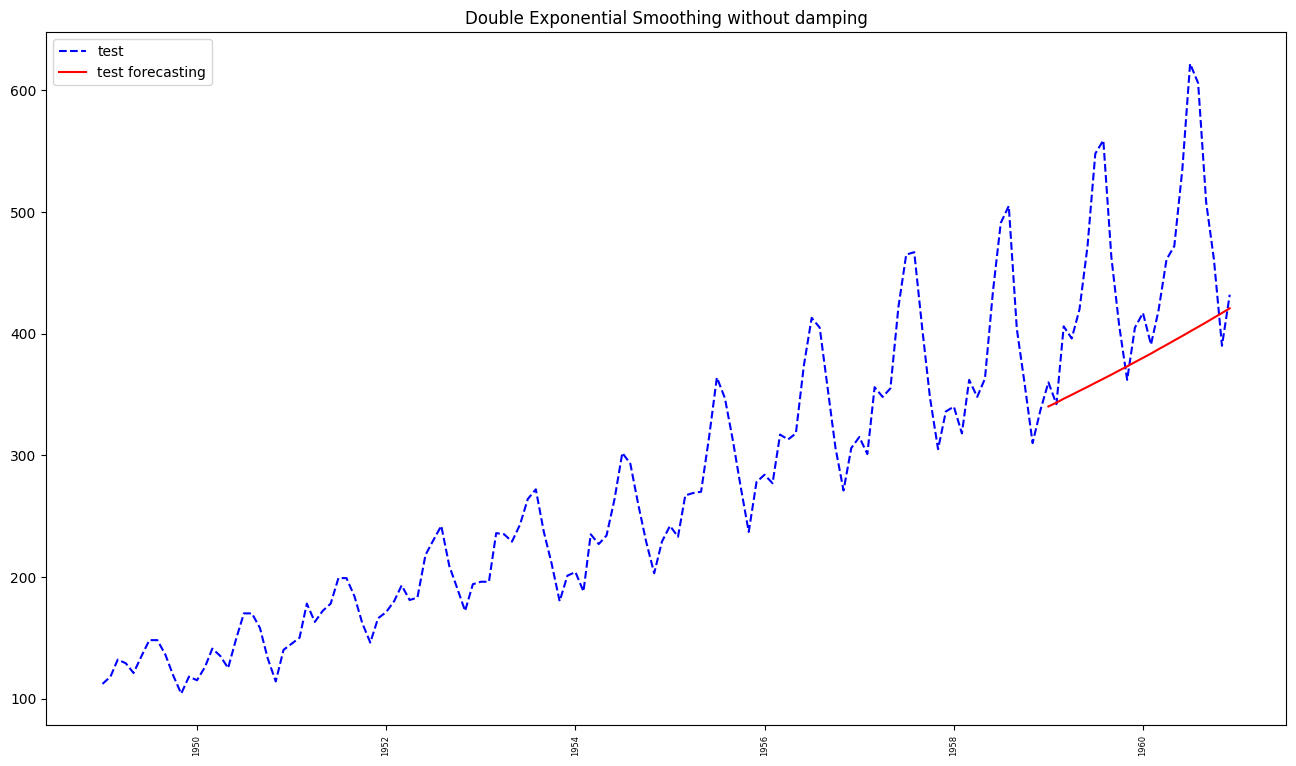

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[-24:],np.exp(test_preds[-24:]), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),rolling_forecast,120,Double_Exp_Smoothing)

rolling_forecast RMSE: 52.17918056424029


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = rolling_forecast(np.log(df['Passengers'].copy()),120,Double_Exp_Smoothing)

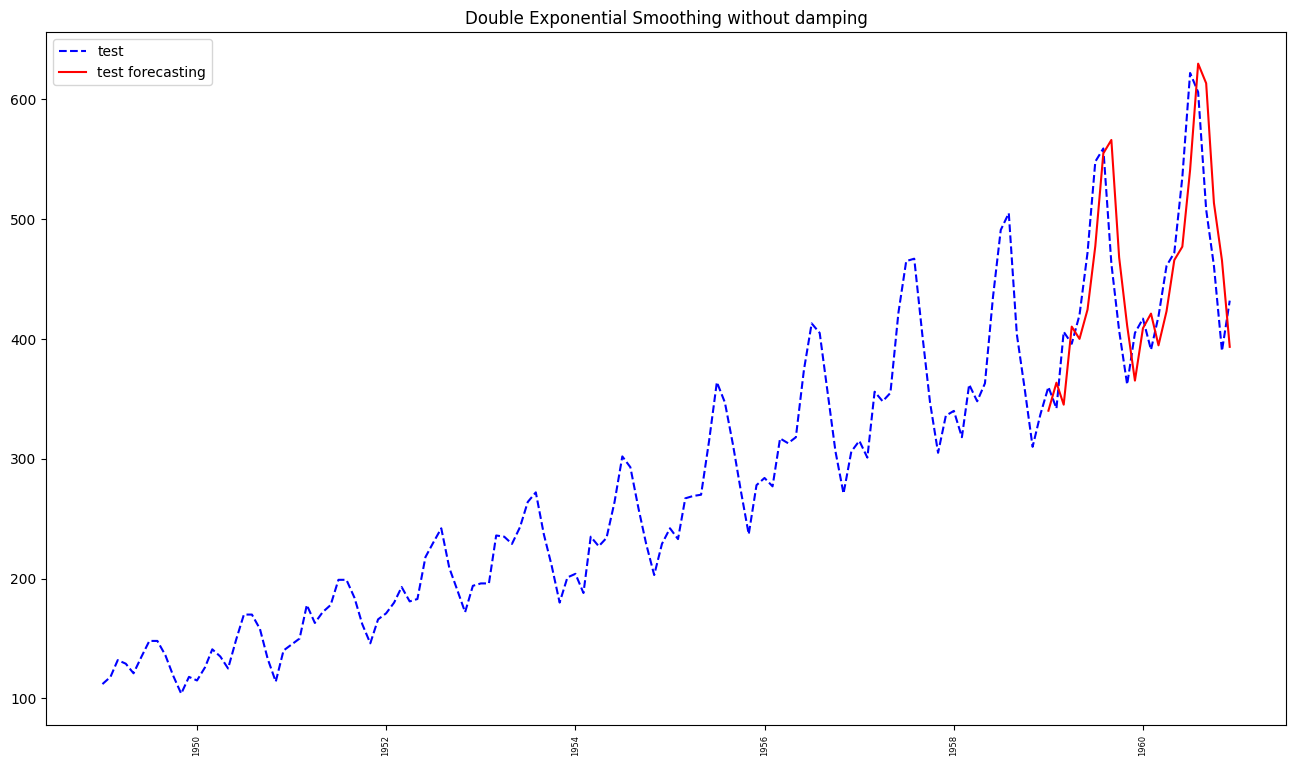

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

### <font color='red'/>__With Damping :__

In [ ]:
# Loading model.
from statsmodels.tsa.api import Holt
def Double_Exp_Smoothing(data) : 
    # Fitting simple exponential smoothing model.
    return Holt(data,damped_trend=True).fit(optimized=True) # optimized=True : Auto Optimization to find value of alpha (smoothing coefficient).

In [ ]:
model_pipeline(df['Passengers'].copy(),Fixed_forecast,120,Double_Exp_Smoothing)

Fixed_forecast RMSE: 137.3289849107372


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = Fixed_forecast(np.log(df['Passengers'].copy()),120,Double_Exp_Smoothing)

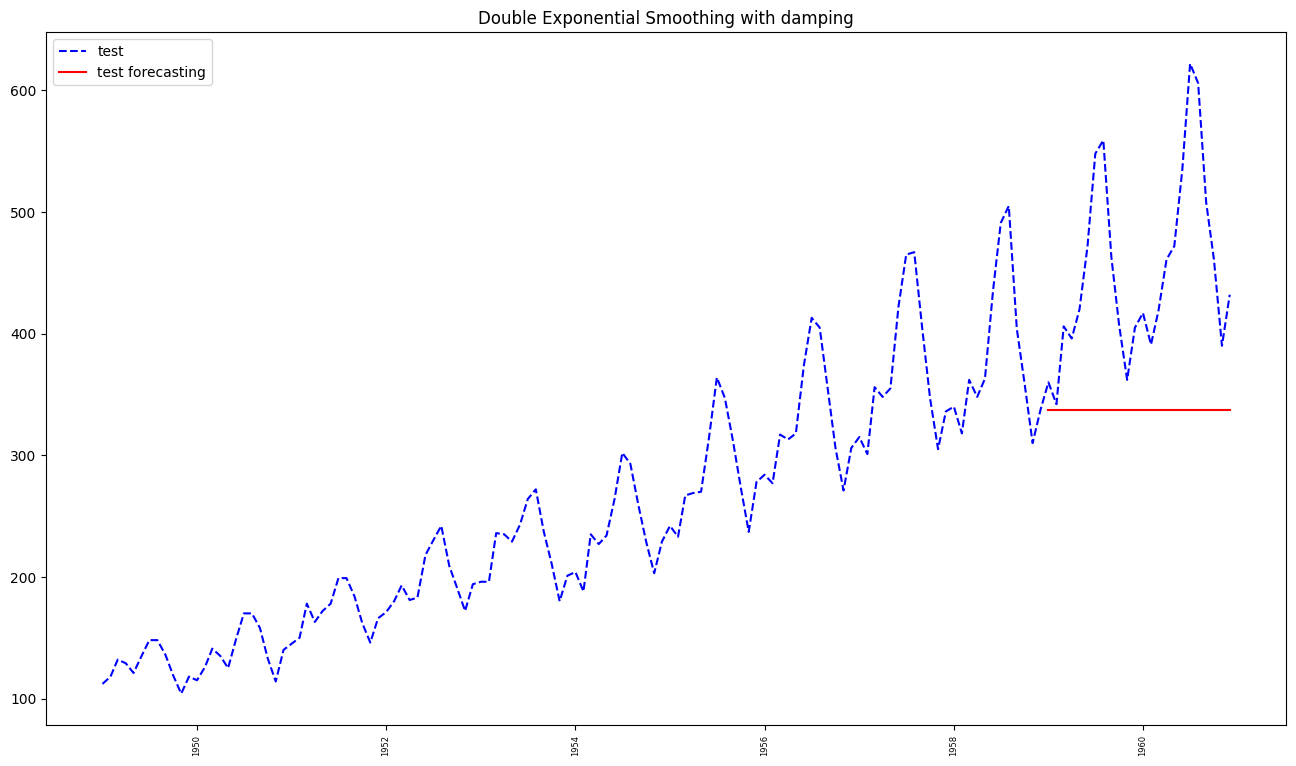

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing with damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),tss_forecast,5,Double_Exp_Smoothing)

tss_forecast RMSE: 88.7168745502425


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = tss_forecast(np.log(df['Passengers'].copy()),5,Double_Exp_Smoothing)

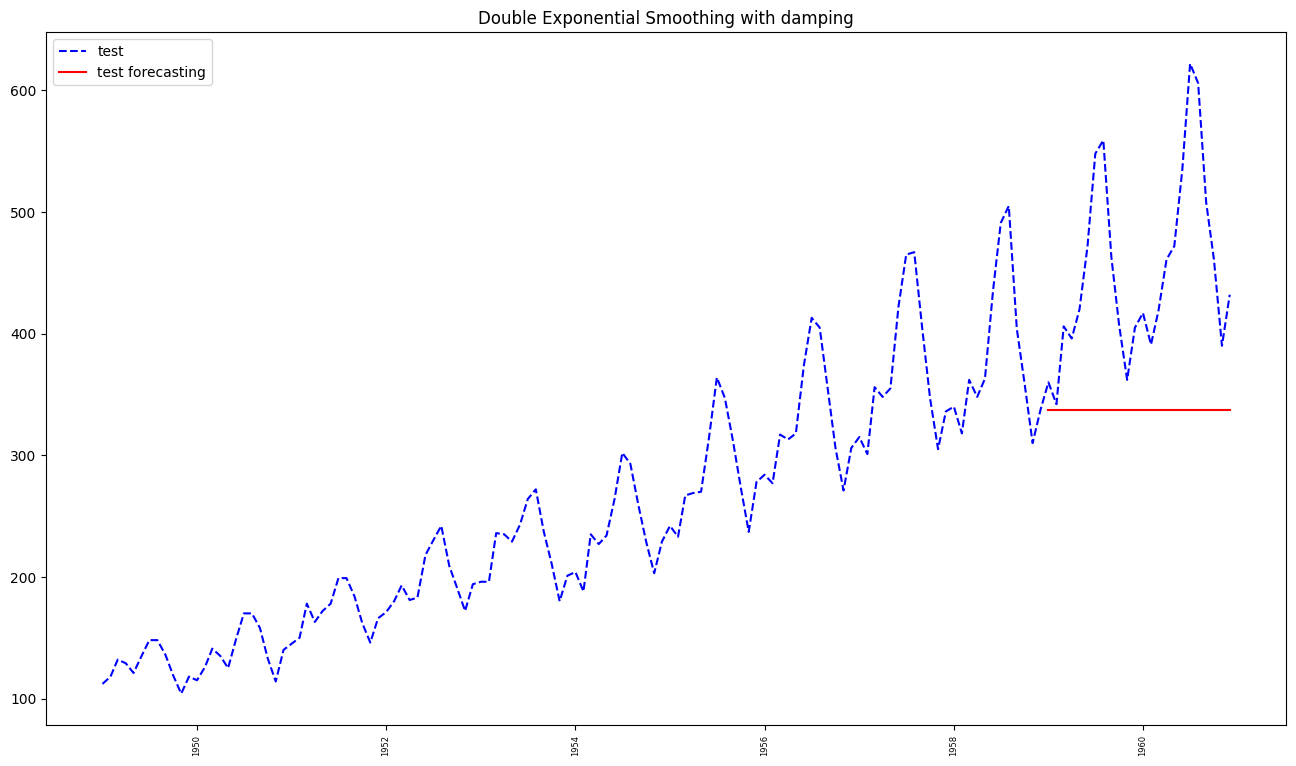

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[-24:],np.exp(test_preds[-24:]), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing with damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),rolling_forecast,120,Double_Exp_Smoothing)

rolling_forecast RMSE: 52.39403952548185


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = rolling_forecast(np.log(df['Passengers'].copy()),120,Double_Exp_Smoothing)

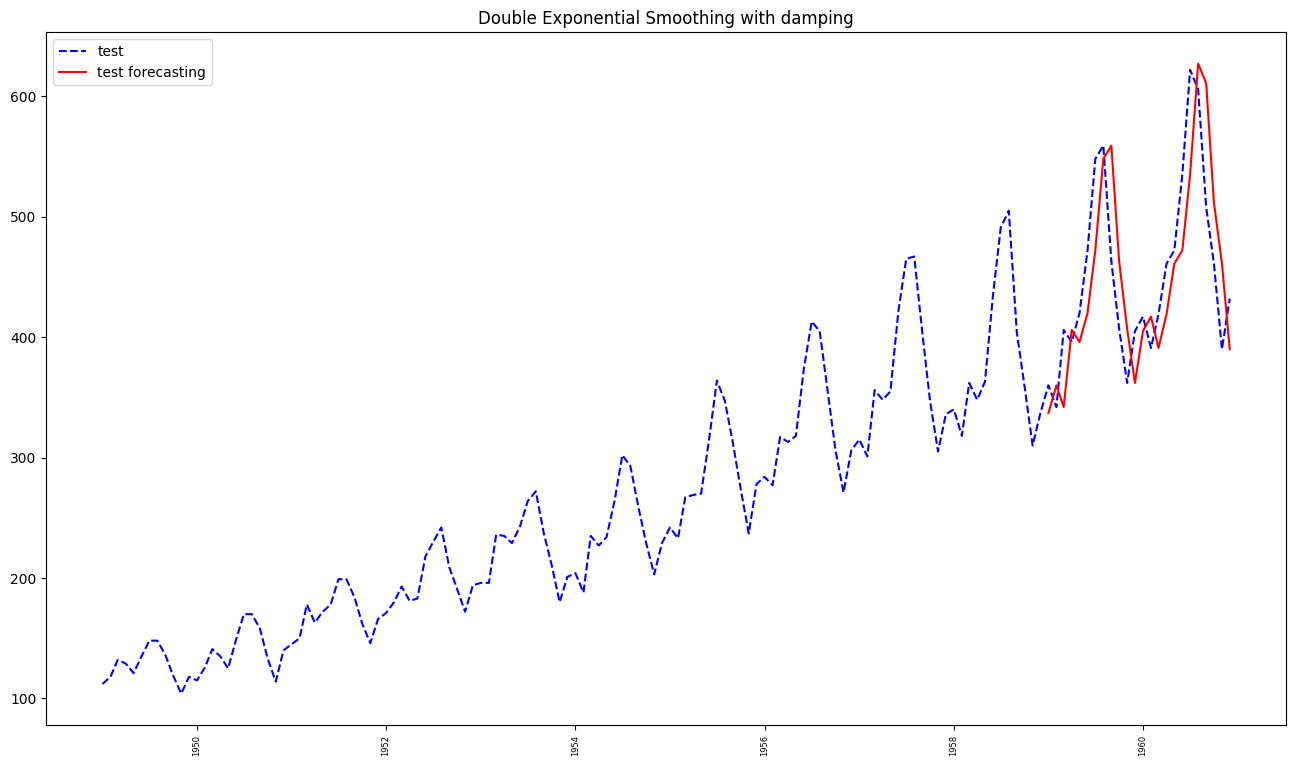

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing with damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

## <font color = 'red'/> ___when damping killed the trend so it looks like single smoothing___

# Conclusion after using <font color='magneta'>__Double exponential smoothing :__</font>  <br>

1-Type of Trend is Additive <br>
2-Double exponential smoothing forecasts level and trend only and ignored seasonality. <br>
3-It predicted values after training data by appling : F<sub>n+k</sub> = L<sub>n</sub> + k*T<sub>n</sub> . <br>
4-Damping affected the slope of the line (decreased). <br>
5-Mean square error is bigger than single exponential smoothing because the predicted line by <font color='red'>double</font> is farther from actual data than the predicted line by <font color='red'>single</font>
***

<a id='Triple_exponential_smoothing'></a>
# Predicting with <font color='magneta'/>__Triple Exponential Smoothing :__

### <font color='red'/>__Without Damping :__

In [ ]:
# Loading model.
from statsmodels.tsa.api import ExponentialSmoothing
def Triple_Exp_Smoothing(data) : 
    # Fitting simple exponential smoothing model.
    return ExponentialSmoothing(data,
                                trend="additive",
                                seasonal="additive",
                                seasonal_periods=12,
                                ).fit(optimized=True) # optimized=True : Auto Optimization to find value of alpha (smoothing coefficient).

In [ ]:
model_pipeline(df['Passengers'].copy(),Fixed_forecast,120,Triple_Exp_Smoothing)

Fixed_forecast RMSE: 37.017450571205394


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = Fixed_forecast(np.log(df['Passengers'].copy()),120,Triple_Exp_Smoothing)

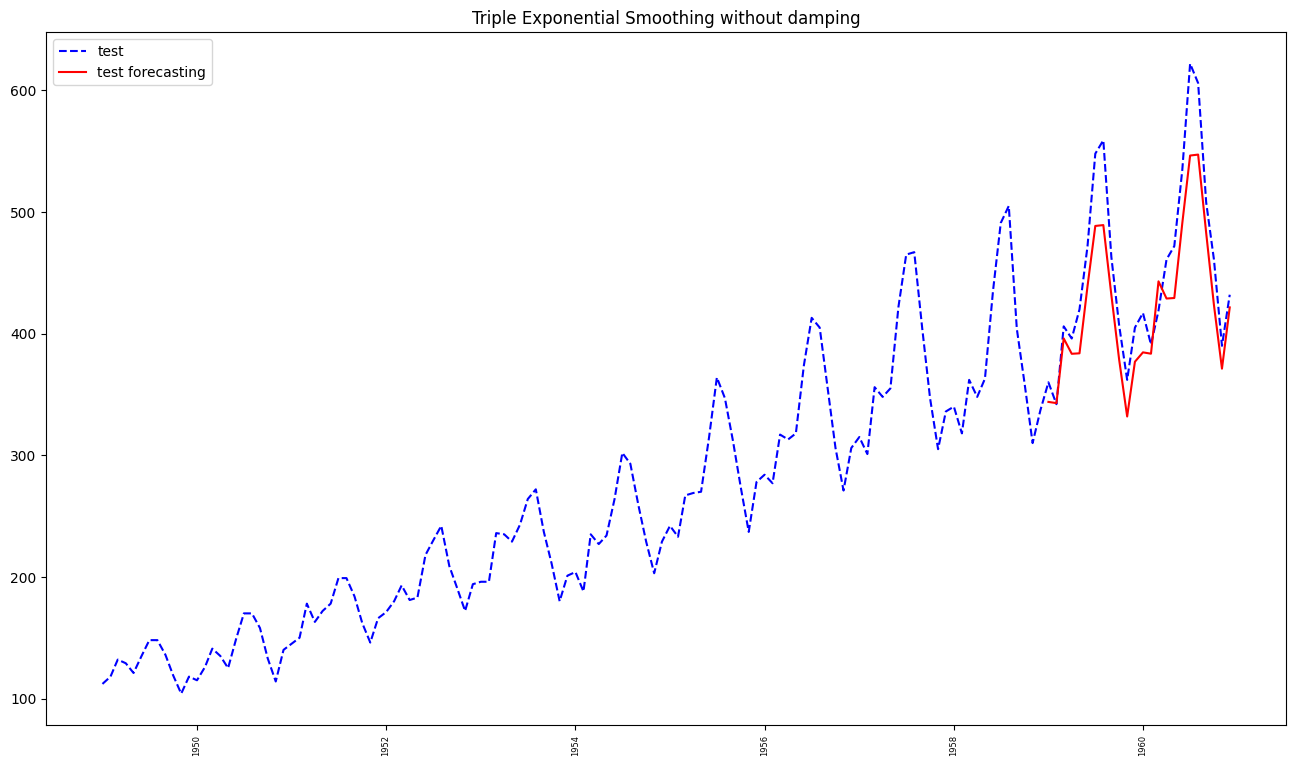

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),tss_forecast,5,Triple_Exp_Smoothing)

tss_forecast RMSE: 26.431521553038348


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = tss_forecast(np.log(df['Passengers'].copy()),5,Triple_Exp_Smoothing)

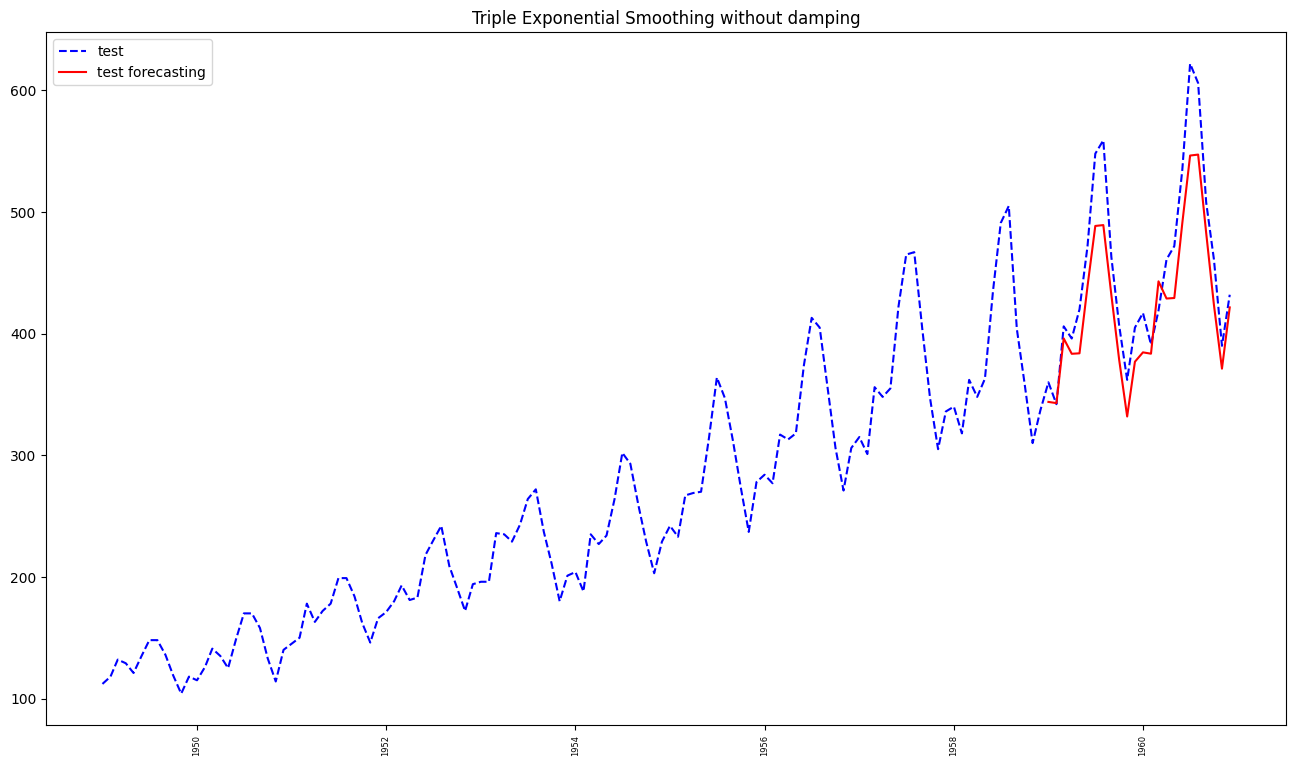

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[-24:],np.exp(test_preds[-24:]), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),rolling_forecast,120,Triple_Exp_Smoothing)

rolling_forecast RMSE: 17.07293896983767


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = rolling_forecast(np.log(df['Passengers'].copy()),120,Triple_Exp_Smoothing)

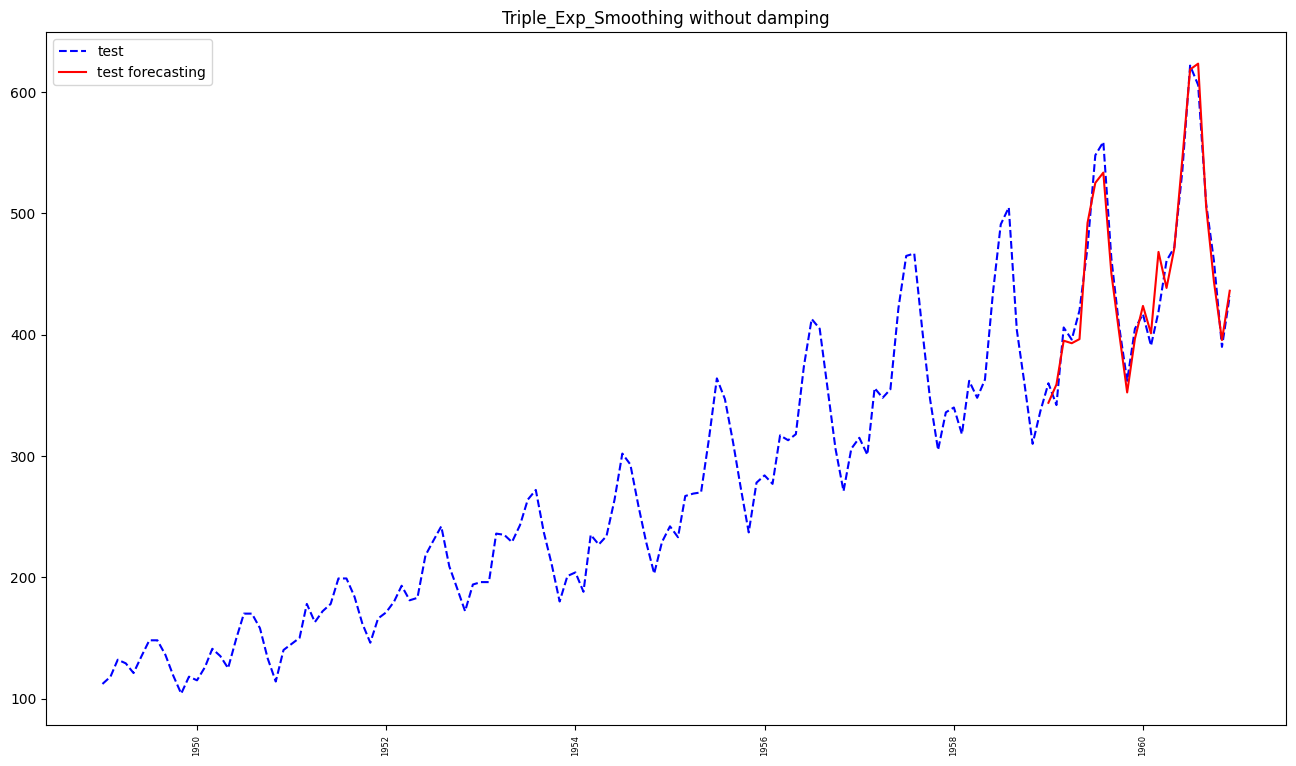

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple_Exp_Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

### <font color='red'/>__With Damping :__

In [ ]:
# Loading model.
from statsmodels.tsa.api import ExponentialSmoothing
def Triple_Exp_Smoothing(data) : 
    # Fitting simple exponential smoothing model.
    return ExponentialSmoothing(data,
                                trend="additive",
                                seasonal="additive",
                                seasonal_periods=12,
                                damped_trend=True
                                ).fit(optimized=True) # optimized=True : Auto Optimization to find value of alpha (smoothing coefficient).

In [ ]:
model_pipeline(df['Passengers'].copy(),Fixed_forecast,120,Triple_Exp_Smoothing)

Fixed_forecast RMSE: 28.337694944705532


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = Fixed_forecast(np.log(df['Passengers'].copy()),120,Triple_Exp_Smoothing)

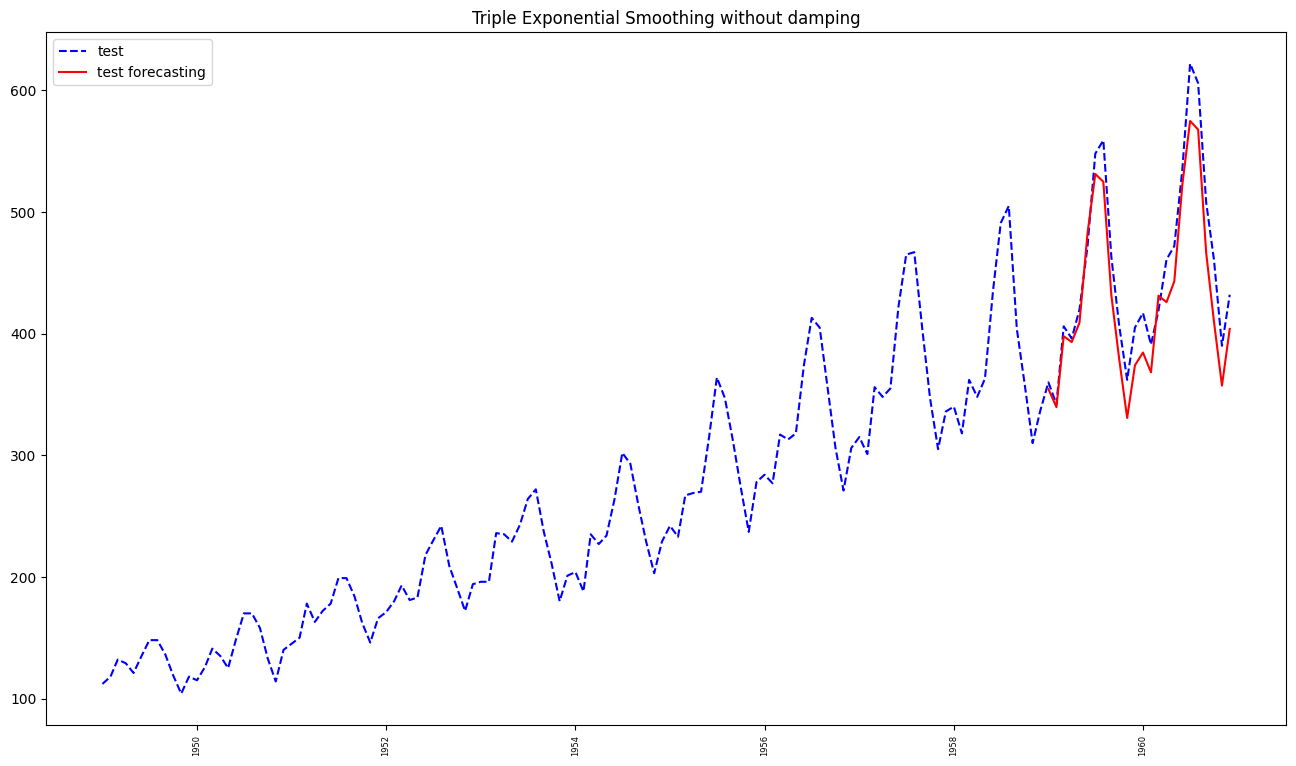

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),tss_forecast,5,Triple_Exp_Smoothing)

tss_forecast RMSE: 26.917603694162533


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = tss_forecast(np.log(df['Passengers'].copy()),5,Triple_Exp_Smoothing)

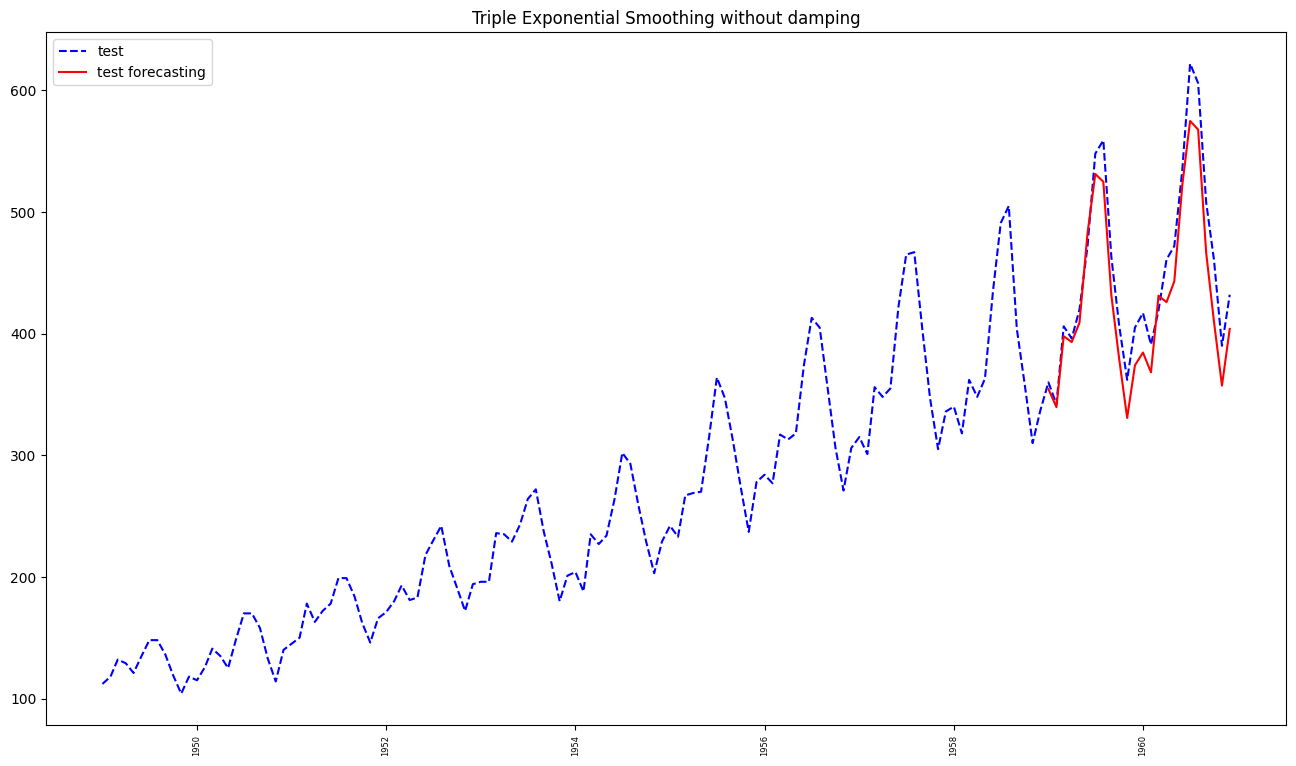

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[-24:],np.exp(test_preds[-24:]), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

In [ ]:
model_pipeline(df['Passengers'].copy(),rolling_forecast,120,Triple_Exp_Smoothing)

rolling_forecast RMSE: 15.699990759708612


In [ ]:
# Actuals and Predictions For Test
test_actuals , test_preds = rolling_forecast(np.log(df['Passengers'].copy()),120,Triple_Exp_Smoothing)

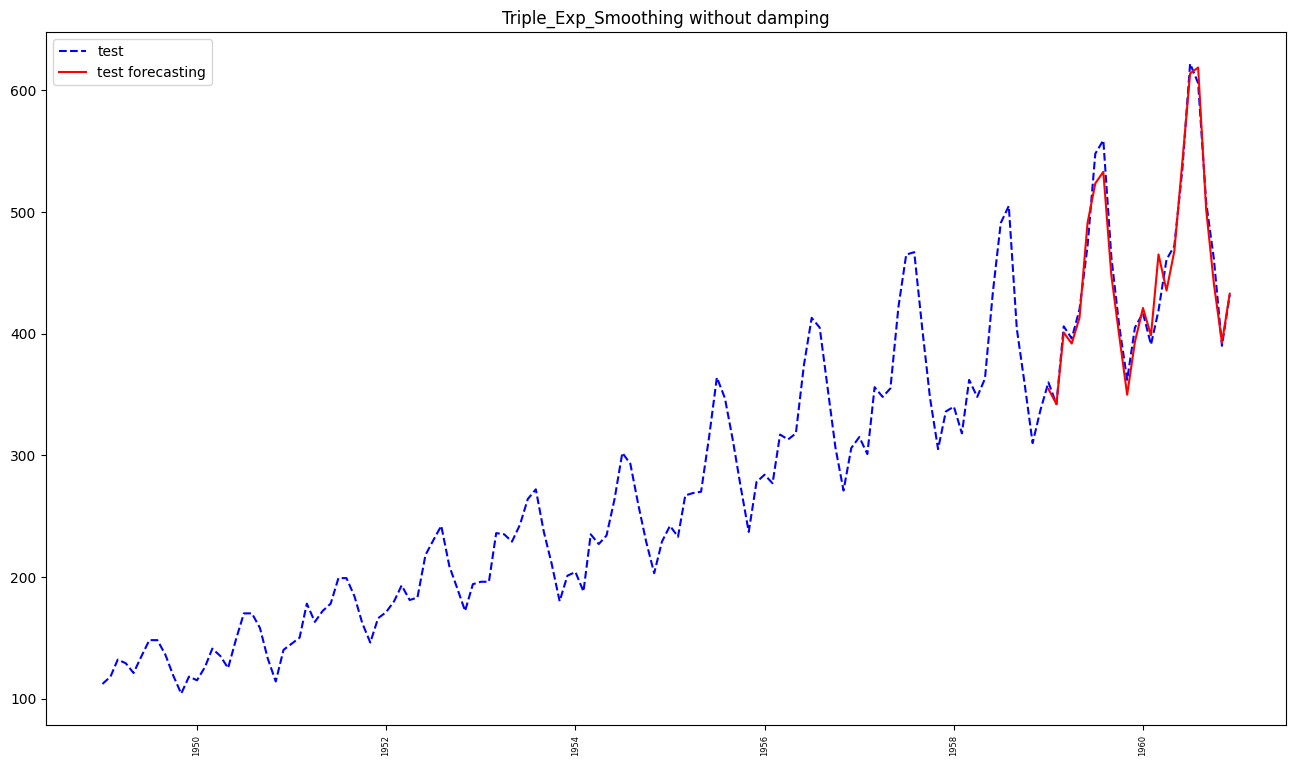

In [ ]:
plt.figure(figsize=(16,9))
# Plot test data.
plt.plot(df.Month,df.Passengers, color='blue', linestyle="--", label="test")
# Plot test forecasting.
plt.plot(df.Month[120:], np.exp(test_preds), 'r', label="test forecasting")


plt.legend(loc='upper left')
plt.title("Triple_Exp_Smoothing without damping")
plt.xticks(rotation = 90, fontsize=6) # Rotates X-Axis Ticks by 90-degrees
plt.show()

# Conclusion after using <font color='magneta'>__Triple exponential smoothing :__</font>  <br>

1-Type of trend is additive and Type of seasonality is additive <br>
2-Triple exponential smoothing forecasts level ,trend and seasonality. <br>
3-Damping affected the slope of the line (decreased). <br>
4-Mean square error is less than mse in single or double smoothing. <br>
5-Using Damping  decreased mean square error.<br>
***

# General Conclusion For <font color='magneta'>__Exponential smoothing :__</font>  <br>

1-Triple exponential smoothing forecasts level ,trend and seasonality. <br>
2-Damping affects the trend of the prediciton. <br>
3-Mean square error is less than mse in single or double smoothing. <br>
4-Mean square error is less than mse in Rolling-Forward. <br>
6-Rolling-Forward makes single and double evaluation like triple and that is not acceptable because each model captures different things.
***

<a id='Supervised Machine Learning Algorithms'></a>
# 10. Predicting with <font color='magneta'/>__Supervised Machine Learning Algorithms :__

###  <font color='blue'/>__Using Xgboost__

###  <font color='red'/>__With lagging (Lag 1 only) :__

In [ ]:
# function to get indices of desired pair of data with desired lags.
def get_indices_entire_sequence(
    data: pd.DataFrame, 
    lags : list,
    step_size: int
    ):
        """
            Produce all the start and end index positions that is needed to produce
            the sub-sequences. 
            Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
            sequence. These tuples should be used to slice the dataset into sub-
            sequences. These sub-sequences should then be passed into a function
            that slices them into input and target sequences. 
            
            Args:
                data (pd.DataFrame): Partitioned data set, e.g. training data
                
                lags (list): list of desired lags(int)
                step_size (int): Size of each step as the data sequence is traversed 
                                by the moving window.
                                If 1, the first sub-sequence will be [0:window_size], 
                                and the next will be [1:1+window_size].
            Return:
                indices: a list of tuples
            """
        indices = []
        
        for lag in lags :
                        
            # Start the first sub-sequence at index position 0
            subseq_first_idx = 0
            subseq_last_idx = lag
                        
            while subseq_last_idx <= len(data)-1:

                indices.append((subseq_first_idx, subseq_last_idx))
                
                subseq_first_idx += step_size
                
                subseq_last_idx += step_size

        return indices

In [ ]:
# function to get data with desired lags.

def get_xgboost_x_y(
    indices: list, 
    data: np.array,
    ):
    """
    Args:
    
        indices: List of index positions at which data should be sliced
        data: A univariate time series

    Output: 

        all_x: np.array of shape (number of instances, input seq len)
        all_y: np.array of shape (number of instances, target seq len)
    """
    print("Preparing data..")
    
    # Loop over list of training indices
    for i, idx in enumerate(indices):
        
        x = data[idx[1]]
        y = data[idx[0]]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y

In [ ]:
# Train test split with respect to order
train_size = int(supervised_df.shape[0] * 0.8)
training_data, test_data = supervised_df.iloc[:train_size,:] , supervised_df.iloc[train_size:, :]

# Create indices. Must be passed to function that creates (X,Y) pairs so that
# it knows where to slice the data
training_indices = get_indices_entire_sequence(
    data=training_data, 
    lags=[1],
    step_size=1
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = get_xgboost_x_y(
    indices=training_indices, 
    data=training_data["Log_Passengers"].to_numpy()
    )

test_indices = get_indices_entire_sequence(
    data=test_data, 
    lags=[1],
    step_size=1
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = get_xgboost_x_y(
    indices=test_indices, 
    data=test_data["Log_Passengers"].to_numpy()
    )

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [ ]:
import xgboost

model = xgboost.XGBRegressor(
    n_estimators=30,
    max_depth=2,
    objective="reg:squarederror",
    eval_metric=mean_squared_error
    )

trained_model = model.fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)
test_forecasts = trained_model.predict(x_test)

In [ ]:
mean_squared_error( np.exp(np.append(y_train,y_test,axis=0)) , np.exp(np.append(train_forecasts,test_forecasts,axis=0)) )

1456.1361564727815

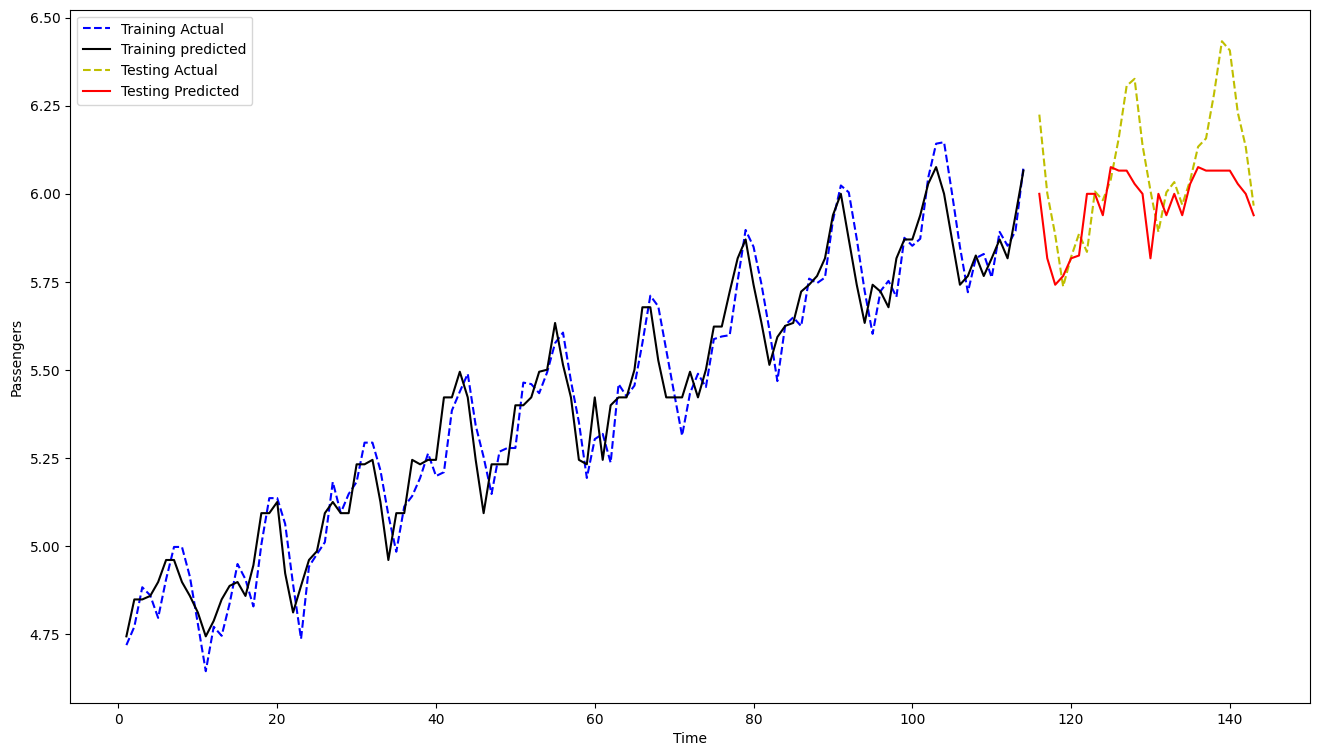

In [ ]:
# Visualizing Facebook prophet model results after reversing the log.
plt.figure(figsize=(16,9))
plt.plot(training_data.index[1:],y_train,'--b') # Training Actual Data
plt.plot(training_data.index[1:],train_forecasts,'k') # Training predicted Data

plt.plot(test_data.index[1:],y_test,'--y' ) # Test Actual Data
plt.plot(test_data.index[1:],test_forecasts,'r') # Test predicted Data

plt.xlabel("Time")
plt.ylabel("Passengers")
plt.legend(['Training Actual','Training predicted','Testing Actual','Testing Predicted'],loc='upper left')
plt.show()

###  <font color='red'/>__With lagging (Multiple Lags) :__

In [ ]:
# Train test split with respect to order
train_size = int(supervised_df.shape[0] * 0.8)
training_data, test_data = supervised_df.iloc[:train_size,:] , supervised_df.iloc[train_size:, :]

# Create indices. Must be passed to function that creates (X,Y) pairs so that
# it knows where to slice the data
training_indices = get_indices_entire_sequence(
    data=training_data, 
    lags=[1,2,3,4],
    step_size=1
    )

# Obtain (X,Y) pairs of training data
x_train, y_train = get_xgboost_x_y(
    indices=training_indices, 
    data=training_data["Log_Passengers"].to_numpy()
    )

test_indices = get_indices_entire_sequence(
    data=test_data, 
    lags=[1,2,3,4],
    step_size=1
    )

# Obtain (X,Y) pairs of test data
x_test, y_test = get_xgboost_x_y(
    indices=test_indices, 
    data=test_data["Log_Passengers"].to_numpy()
    )

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [ ]:
import xgboost

model = xgboost.XGBRegressor(
    n_estimators=30,
    max_depth=2,
    objective="reg:squarederror",
    eval_metric=mean_squared_error
    )

trained_model = model.fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)
test_forecasts = trained_model.predict(x_test)

In [ ]:
mean_squared_error( np.exp(np.append(y_train,y_test,axis=0)) , np.exp(np.append(train_forecasts,test_forecasts,axis=0)) )

3456.2206577705406

# Conclusion after using <font color='blue'>__Supervised Machine Learning :__</font>  <br>

1-Supervised machine learning requries a lot of preprocessing work compared with other forecasting methods. <br>
2-Supervised machine learning doesn't capture seasonality of time series. <br>
3-In Supervised machine learning number of hyperparameters is larger than number of hyperparamters in other forecasting methods. <br>
***

# Final Conclusion

# After using multiple forcasting algorithms we can find that Tripple Exponential with Damping is the best model that has RMSE = 15.69